# Air Quality Regression Analysis with Lasso and Ridge Regression

In [1]:
# Current R version
R.Version()$version.string

[1] "R version 4.3.2 (2023-10-31 ucrt)"

## Load Packages

In [2]:
#defaultW <- getOption("warn") 
#options(warn = -1) 

# load libraries

if (!require(tidyverse)) install.packages('tidyverse', dependencies=TRUE)   # data manipulation
suppressWarnings(suppressMessages(library(tidyverse) ))

if (!require(ggplot2)) install.packages('ggplot2', dependencies=TRUE) #  data visualization
suppressWarnings(suppressMessages(library(ggplot2)))

if (!require(caret)) install.packages('caret', dependencies=TRUE) 
suppressWarnings(suppressMessages(library(caret)))

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: caret

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




#### Dataset airquality is a daily record of daily air quality measurements in New York, May to September 1973.

<img src="air-quality.jpg" alt="air-quality-dataset" />
    from: https://static-bcrf.biochem.wisc.edu/courses/Tabular-data-analysis-with-R-and-Tidyverse/book/5-workingwithtabulardata.html#airqualitydataset

In [3]:
df <-airquality
df %>% 
    as_tibble() %>%
    head() # See top 6 rows 

Ozone,Solar.R,Wind,Temp,Month,Day
<int>,<int>,<dbl>,<int>,<int>,<int>
41,190,7.4,67,5,1
36,118,8.0,72,5,2
12,149,12.6,74,5,3
18,313,11.5,62,5,4
NA,NA,14.3,56,5,5
28,NA,14.9,66,5,6


## Exploratory data analysis

In [4]:
# Structure of the dataframe
df %>% str()

'data.frame':	153 obs. of  6 variables:
 $ Ozone  : int  41 36 12 18 NA 28 23 19 8 NA ...
 $ Solar.R: int  190 118 149 313 NA NA 299 99 19 194 ...
 $ Wind   : num  7.4 8 12.6 11.5 14.3 14.9 8.6 13.8 20.1 8.6 ...
 $ Temp   : int  67 72 74 62 56 66 65 59 61 69 ...
 $ Month  : int  5 5 5 5 5 5 5 5 5 5 ...
 $ Day    : int  1 2 3 4 5 6 7 8 9 10 ...


In [5]:
df %>% summary()

     Ozone           Solar.R           Wind             Temp      
 Min.   :  1.00   Min.   :  7.0   Min.   : 1.700   Min.   :56.00  
 1st Qu.: 18.00   1st Qu.:115.8   1st Qu.: 7.400   1st Qu.:72.00  
 Median : 31.50   Median :205.0   Median : 9.700   Median :79.00  
 Mean   : 42.13   Mean   :185.9   Mean   : 9.958   Mean   :77.88  
 3rd Qu.: 63.25   3rd Qu.:258.8   3rd Qu.:11.500   3rd Qu.:85.00  
 Max.   :168.00   Max.   :334.0   Max.   :20.700   Max.   :97.00  
 NA's   :37       NA's   :7                                       
     Month            Day      
 Min.   :5.000   Min.   : 1.0  
 1st Qu.:6.000   1st Qu.: 8.0  
 Median :7.000   Median :16.0  
 Mean   :6.993   Mean   :15.8  
 3rd Qu.:8.000   3rd Qu.:23.0  
 Max.   :9.000   Max.   :31.0  
                               

#### There are NA in Ozone and Solar.R

In [6]:
# replace NA with their mean
df_clean <- df %>%
    mutate_at(c('Ozone','Solar.R'), ~replace_na(., as.integer(mean(., na.rm=TRUE)) ))

In [7]:
df_clean %>% 
    summary()

     Ozone          Solar.R           Wind             Temp      
 Min.   :  1.0   Min.   :  7.0   Min.   : 1.700   Min.   :56.00  
 1st Qu.: 21.0   1st Qu.:120.0   1st Qu.: 7.400   1st Qu.:72.00  
 Median : 42.0   Median :194.0   Median : 9.700   Median :79.00  
 Mean   : 42.1   Mean   :185.9   Mean   : 9.958   Mean   :77.88  
 3rd Qu.: 46.0   3rd Qu.:256.0   3rd Qu.:11.500   3rd Qu.:85.00  
 Max.   :168.0   Max.   :334.0   Max.   :20.700   Max.   :97.00  
     Month            Day      
 Min.   :5.000   Min.   : 1.0  
 1st Qu.:6.000   1st Qu.: 8.0  
 Median :7.000   Median :16.0  
 Mean   :6.993   Mean   :15.8  
 3rd Qu.:8.000   3rd Qu.:23.0  
 Max.   :9.000   Max.   :31.0  

In [8]:
# load package

if (!require(psych)) install.packages('psych') #  data visualization
suppressWarnings(suppressMessages(library(psych)))


df_clean %>% describe()

Loading required package: psych


Attaching package: 'psych'


The following objects are masked from 'package:ggplot2':

    %+%, alpha




,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ozone,1,153,42.098039,28.693426,42.0,38.365854,28.16940,1.0,168.0,167,1.397110346,2.45278491,2.3197260
Solar.R,2,153,185.888889,87.960484,194.0,190.390244,96.36900,7.0,334.0,327,-0.427979038,-0.90789355,7.1111837
Wind,3,153,9.957516,3.523001,9.7,9.869919,3.40998,1.7,20.7,19,0.341027535,0.02886468,0.2848178
Temp,4,153,77.882353,9.465270,79.0,78.284553,8.89560,56.0,97.0,41,-0.370507250,-0.46289287,0.7652217
Month,5,153,6.993464,1.416522,7.0,6.991870,1.48260,5.0,9.0,4,-0.002344810,-1.31674648,0.1145191
Day,6,153,15.803922,8.864520,16.0,15.804878,11.86080,1.0,31.0,30,0.002600083,-1.22244060,0.7166540


In [9]:
options(repr.plot.width = 15, repr.plot.height = 10)

### Boxplots

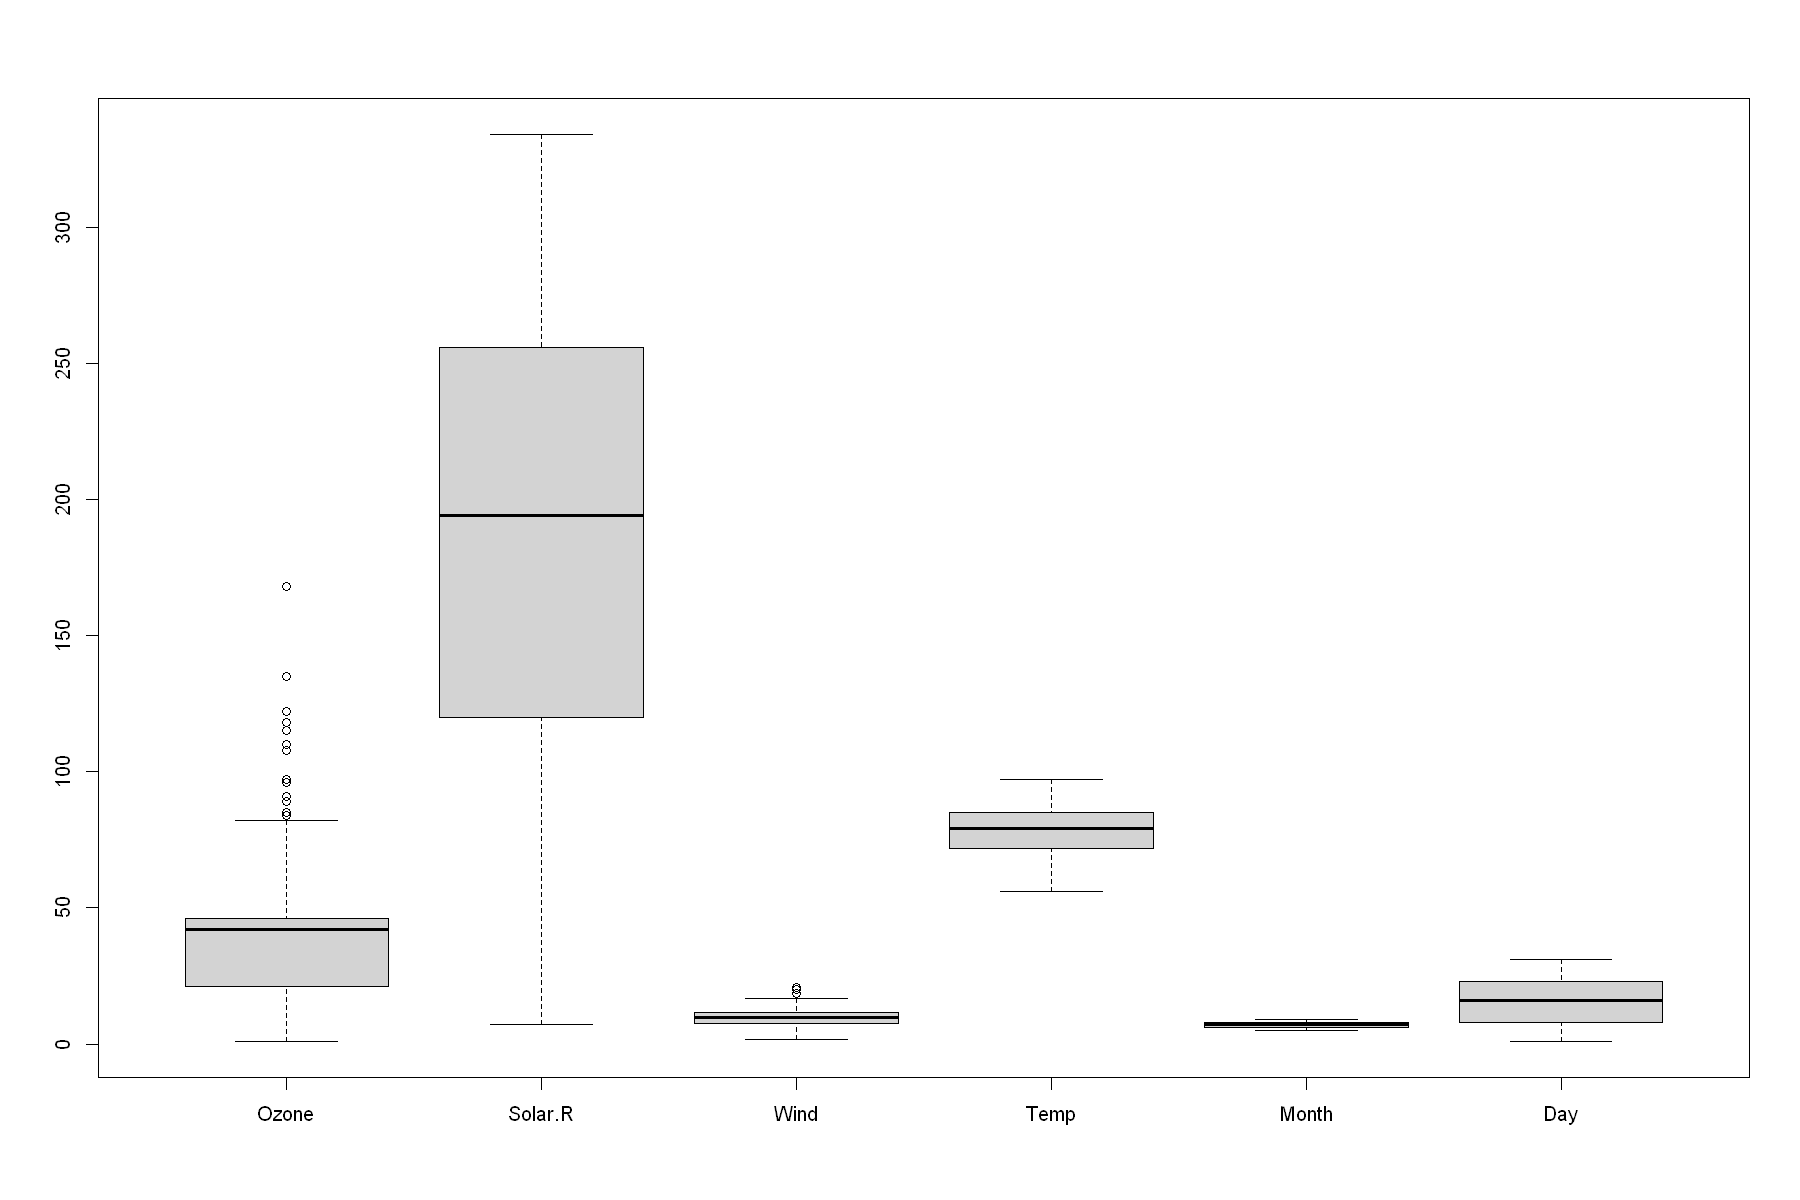

In [10]:
boxplot(df_clean)

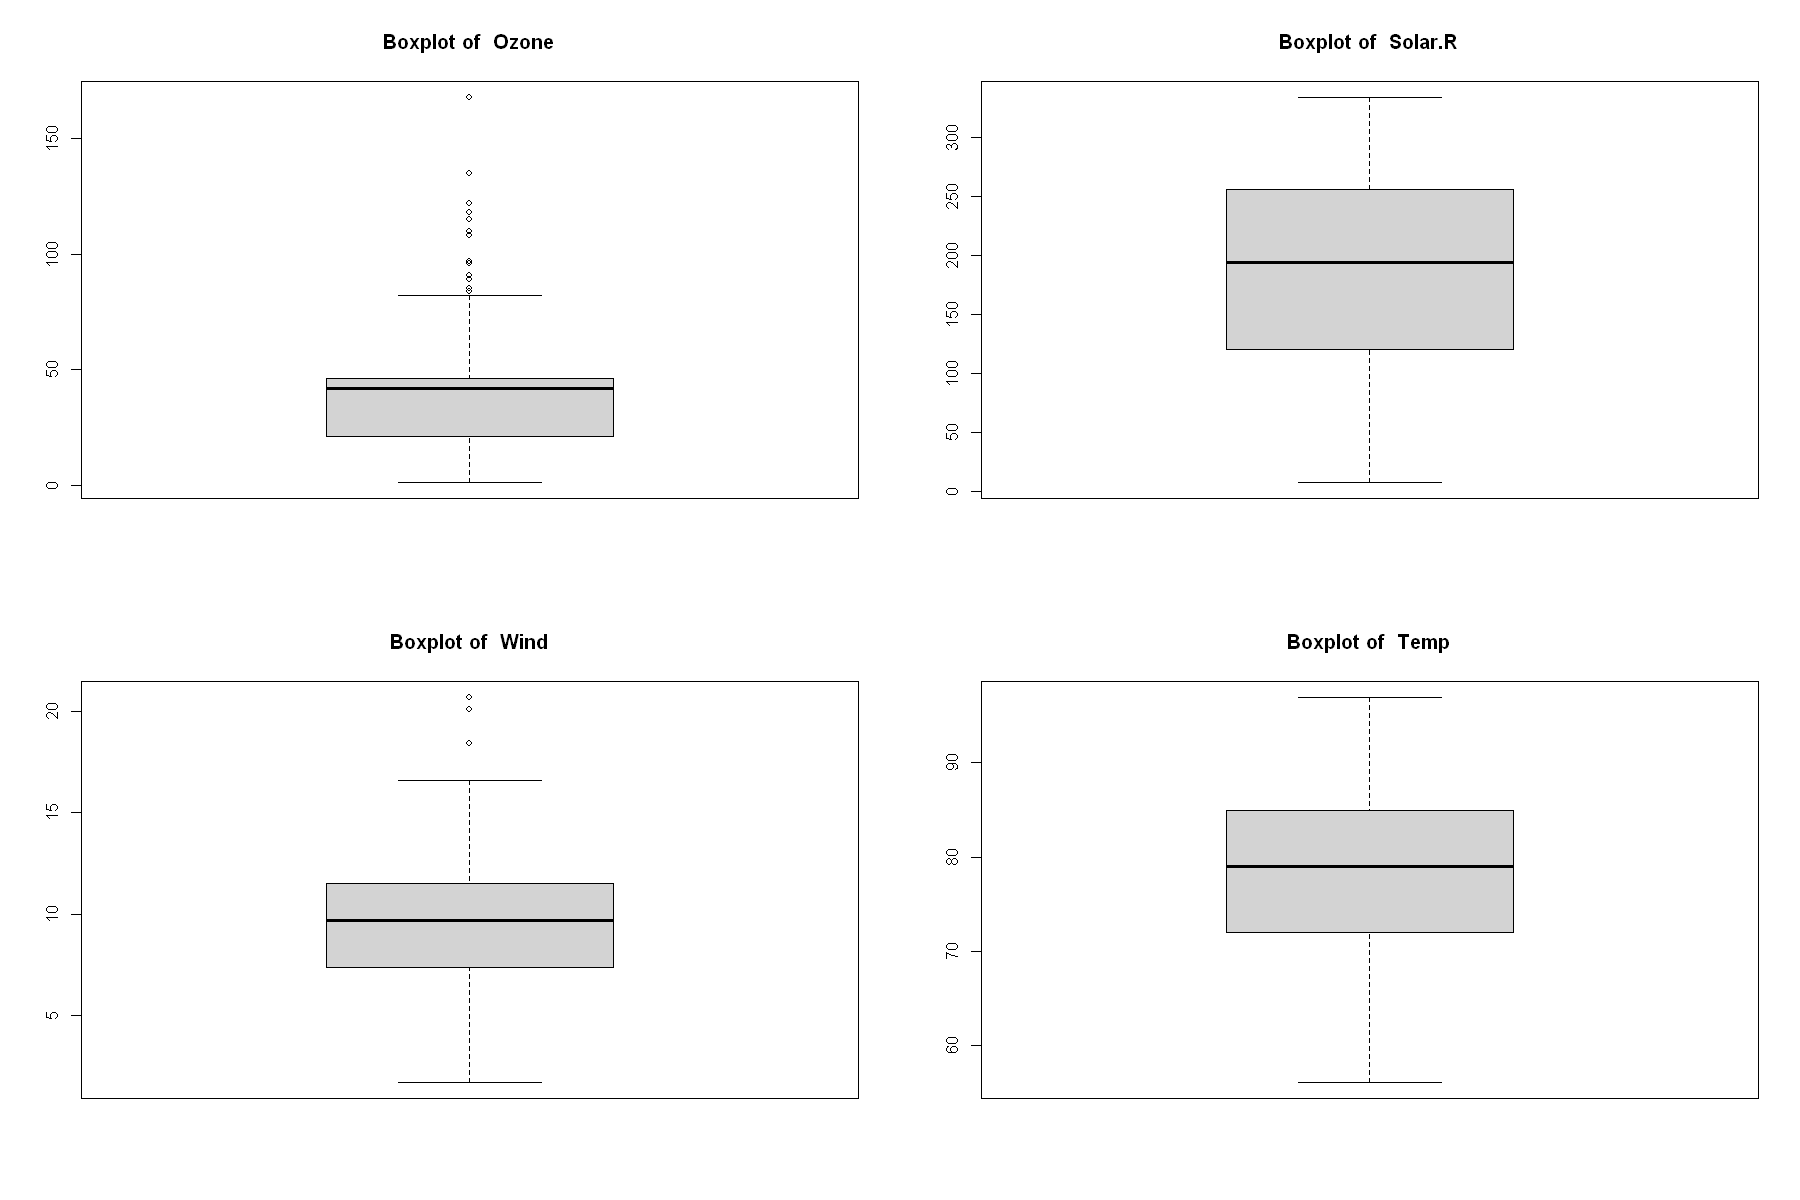

In [11]:
df_num <- subset(df_clean, select = -c(Month,Day))
par(mfrow= c(2,2))
invisible(lapply(names(df_num), 
    function(col_name) boxplot(df_num[,col_name], 
    main = paste("Boxplot of ", col_name), xlab = NA)))

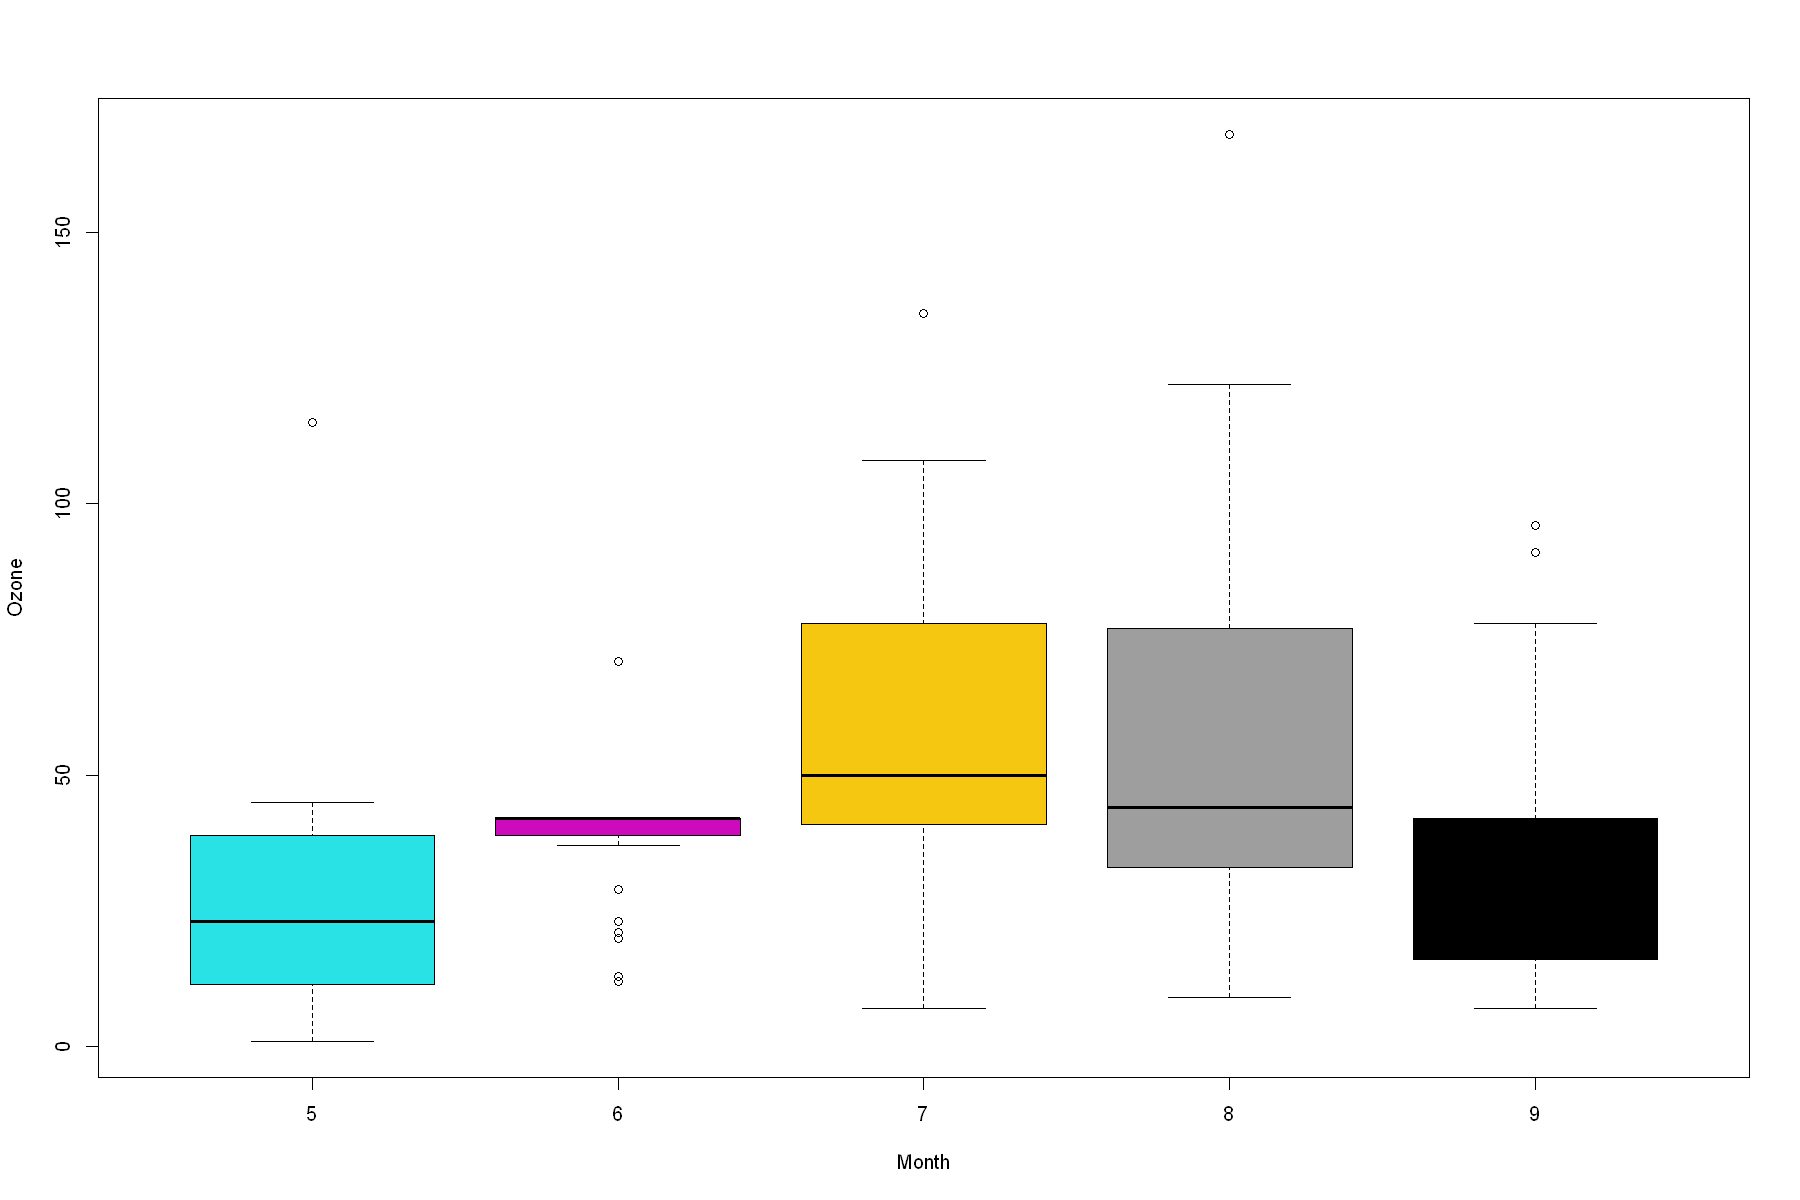

In [12]:
with(df_clean, boxplot(Ozone ~ Month, col=levels(with(df_clean, as.factor(Month)))))

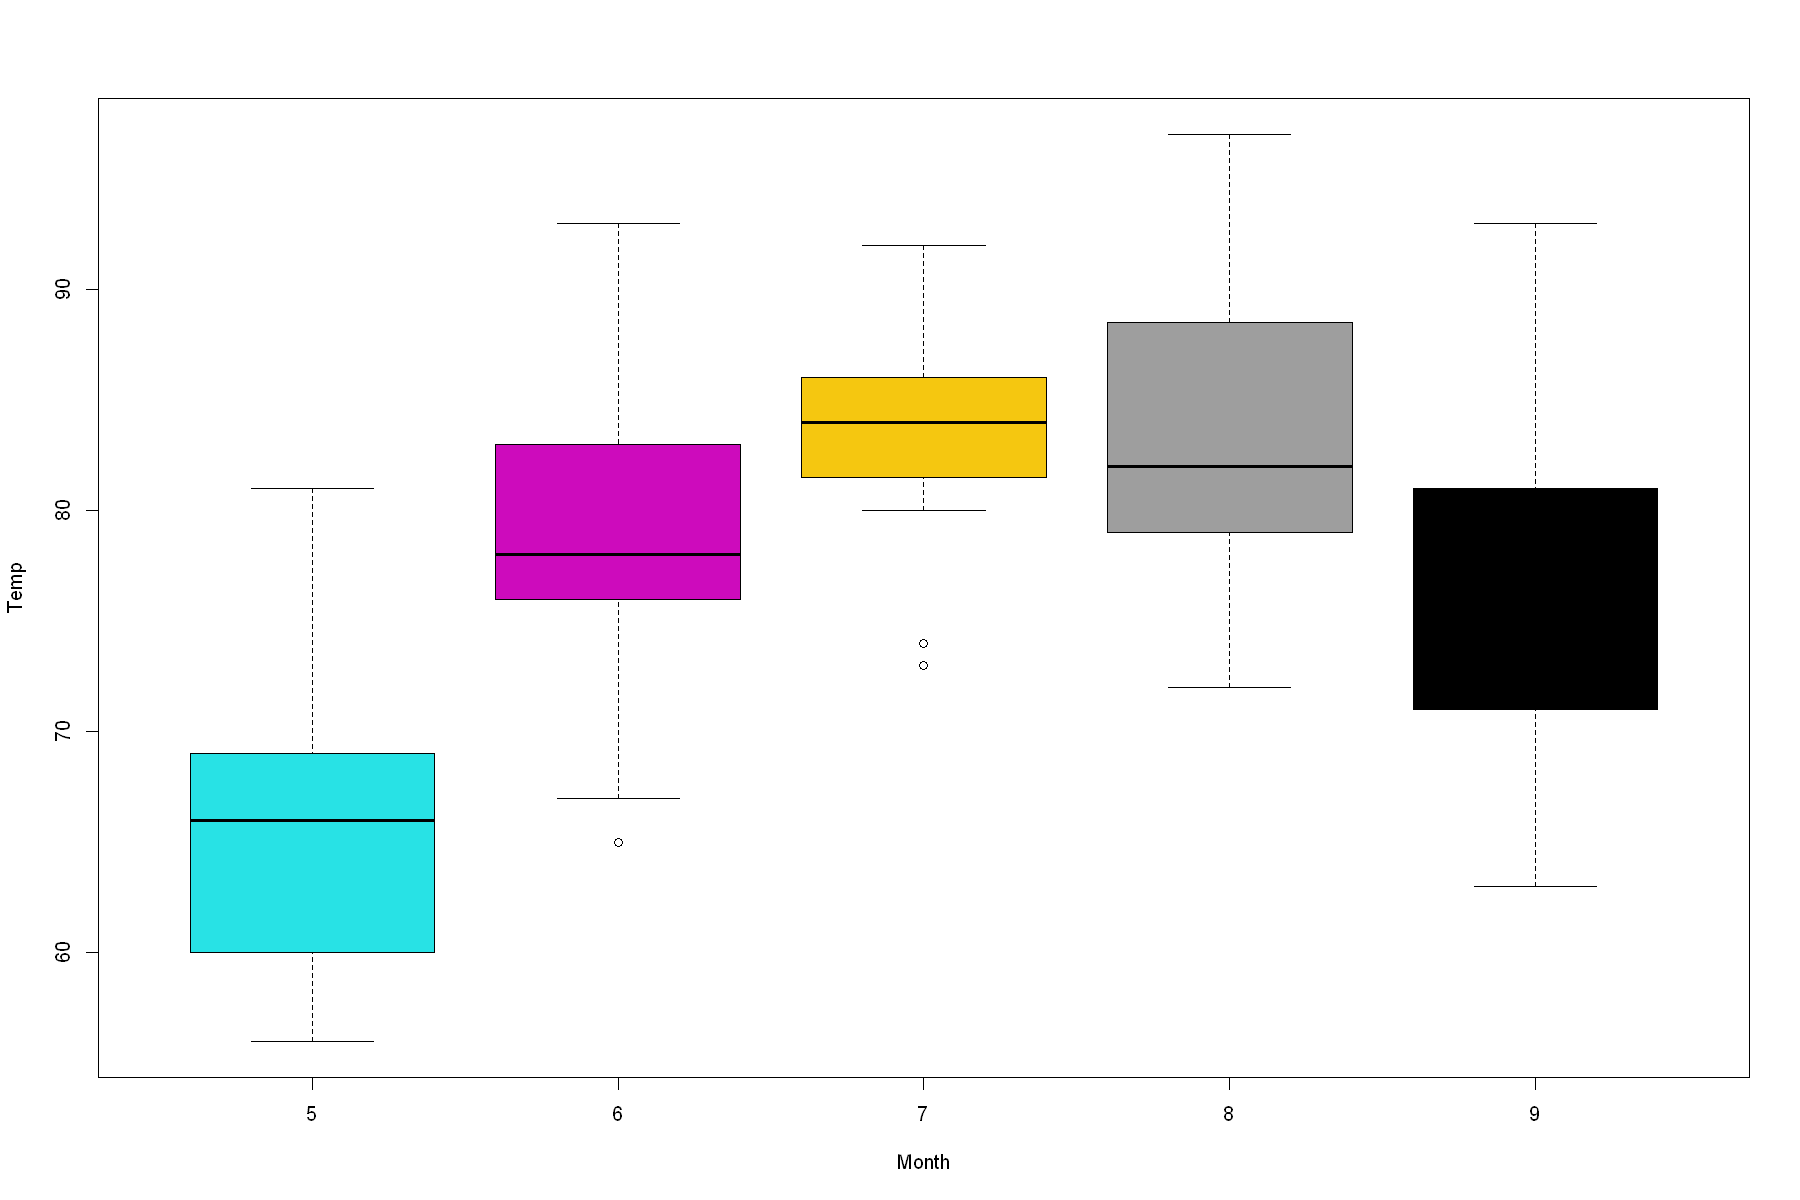

In [13]:
with(df_clean, boxplot(Temp ~ Month, col=levels(with(df_clean, as.factor(Month) ))))

### Histogram

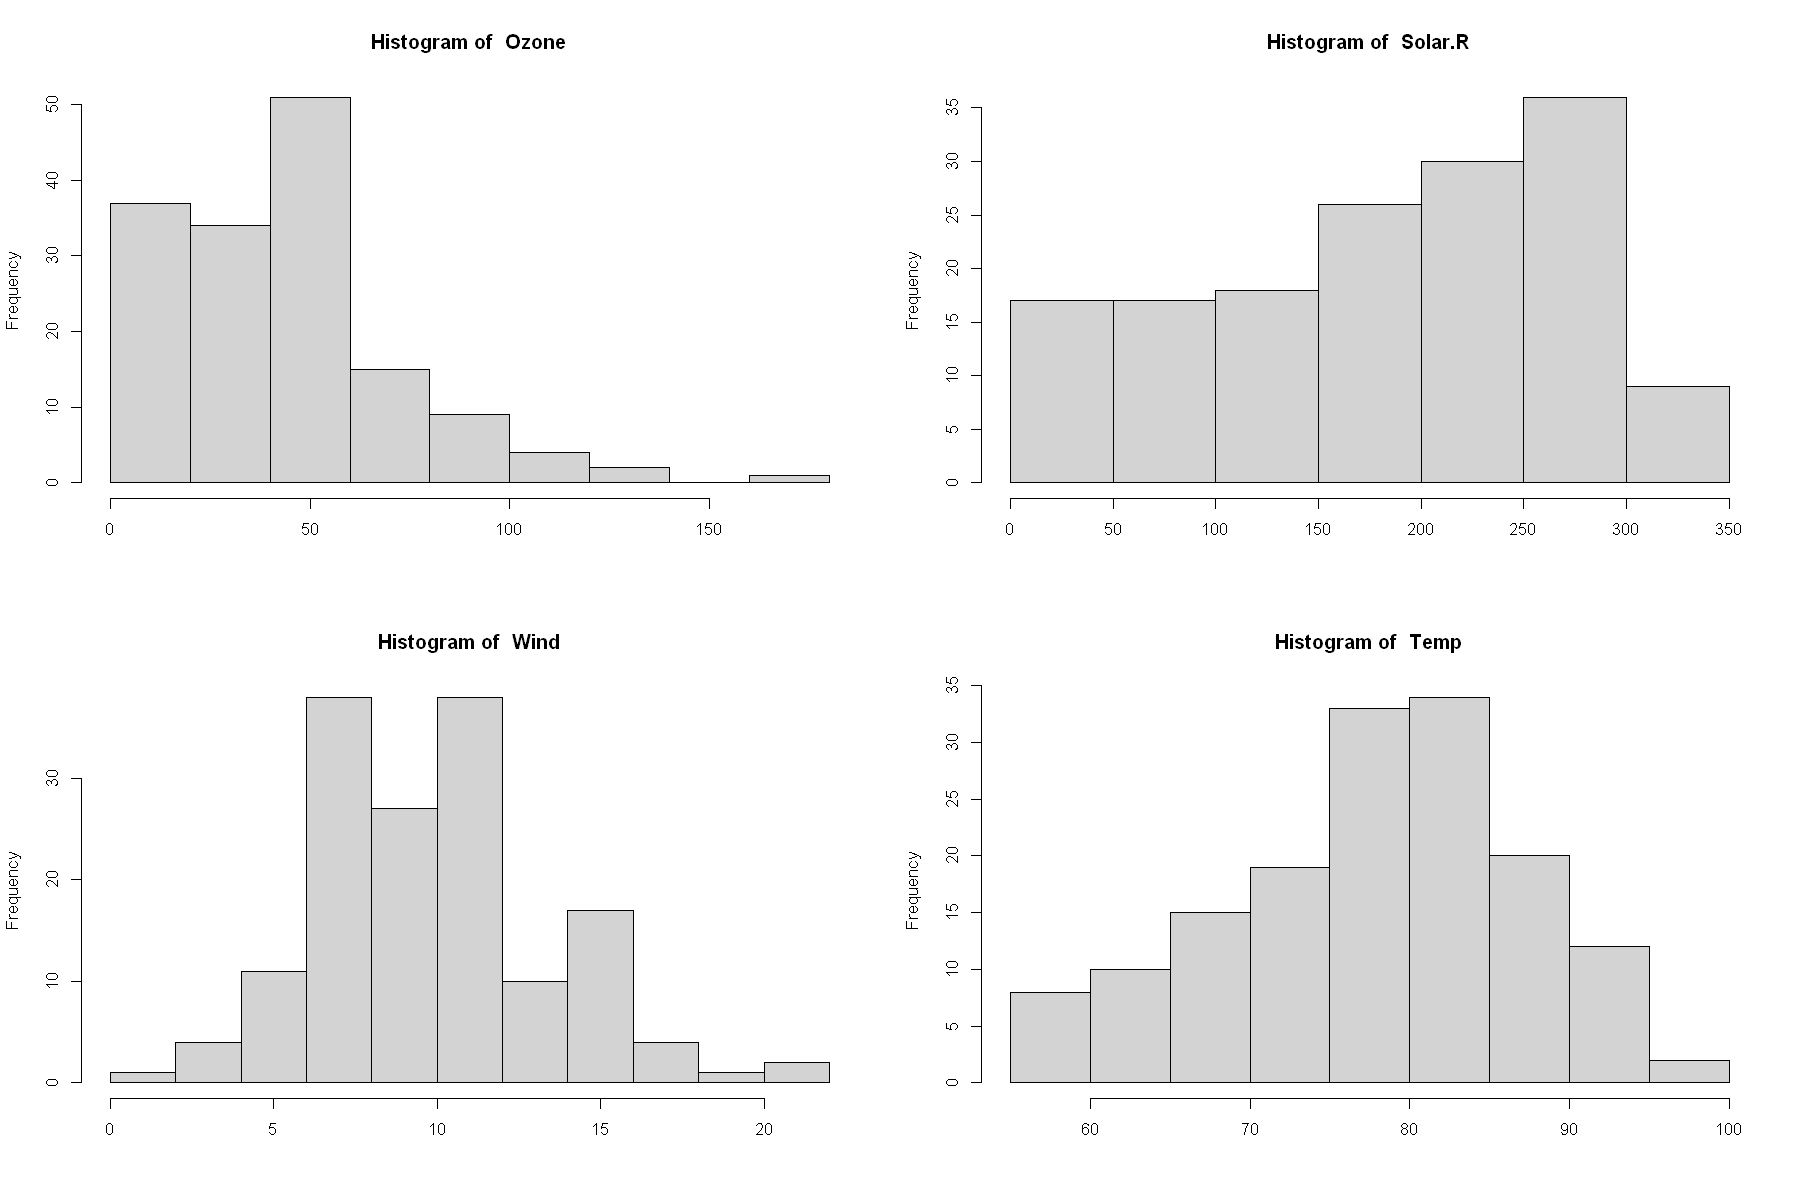

In [14]:
par(mfrow= c(2,2))
invisible(lapply(names(df_num), 
                 function(col_name) hist(df_num[,col_name],
                                         main = paste("Histogram of ", col_name), xlab = NA)))

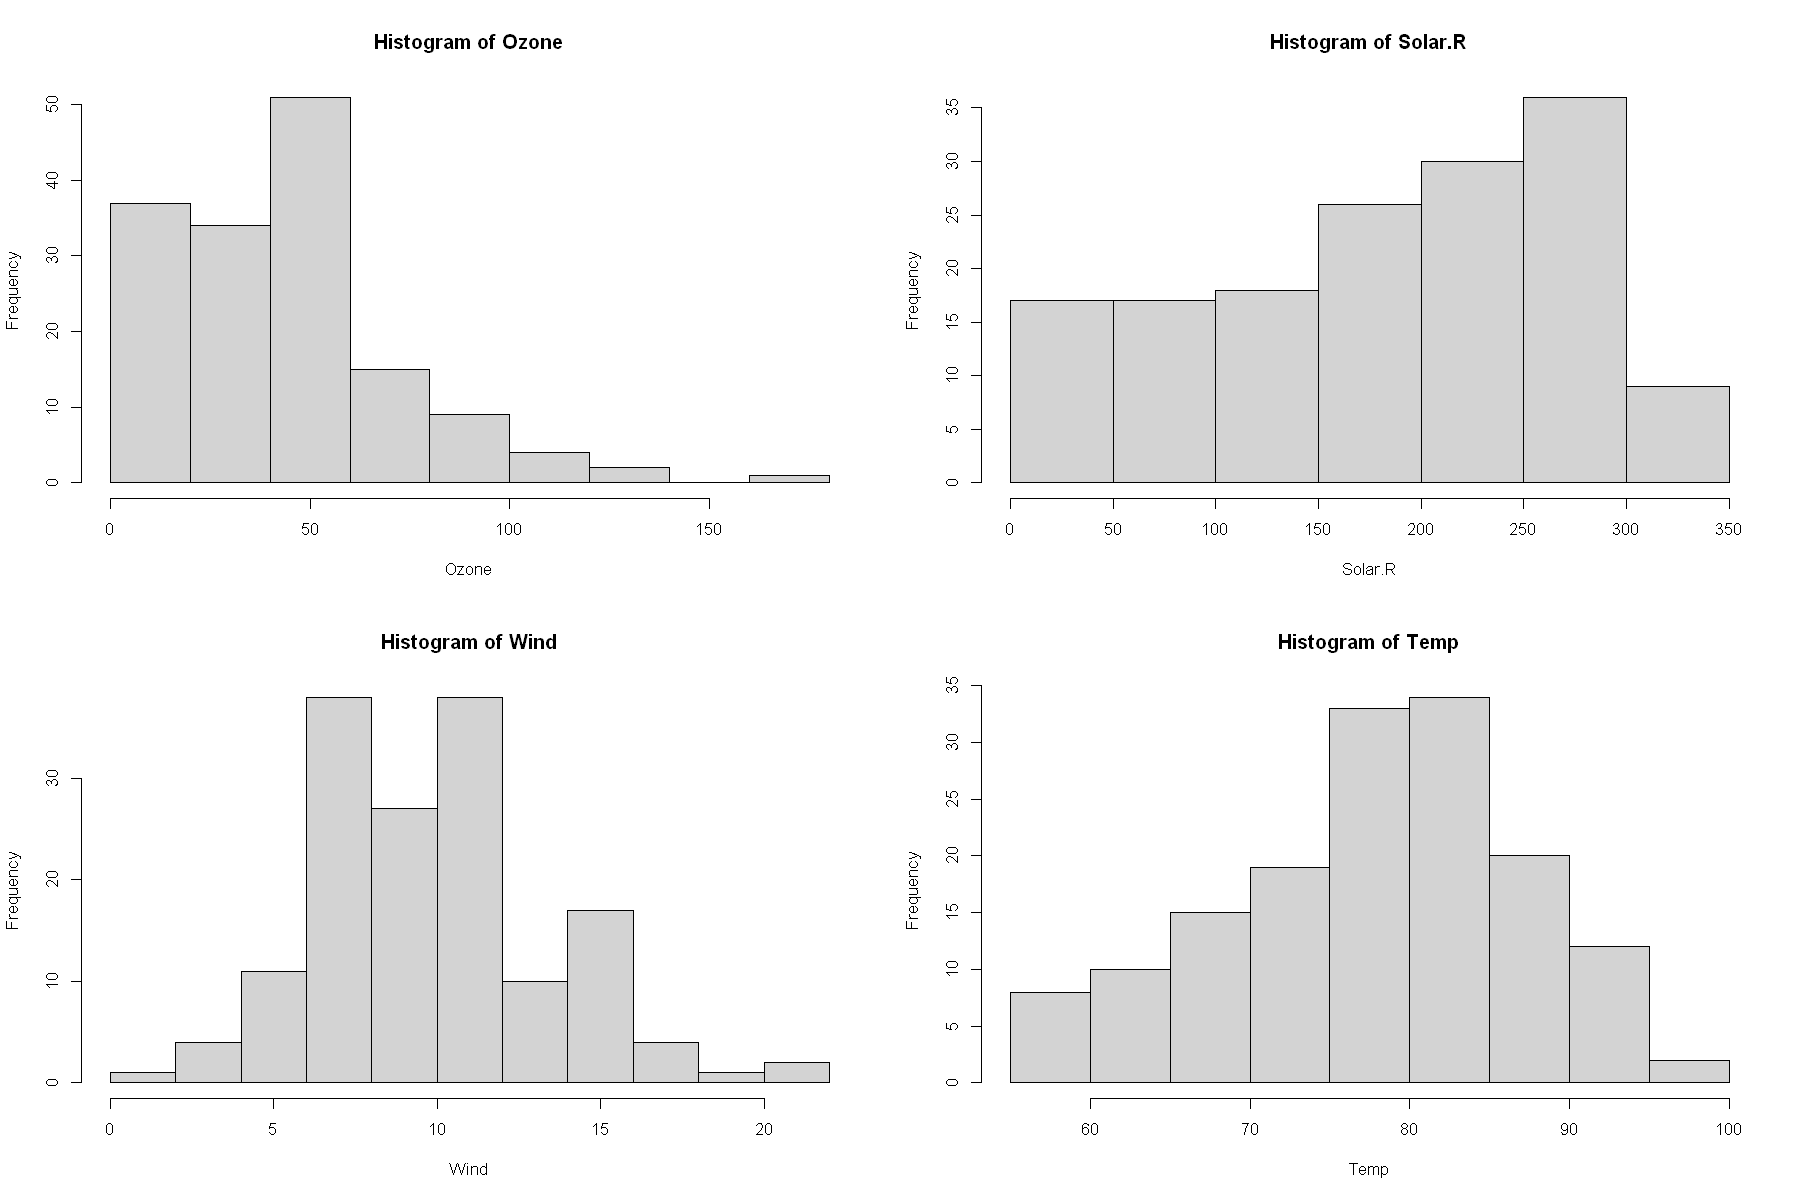

In [15]:
par(mfrow = c(2,2))
with(df_clean, hist(Ozone))
with(df_clean, hist(Solar.R))
with(df_clean, hist(Wind))
with(df_clean, hist(Temp))

### Scatter plots

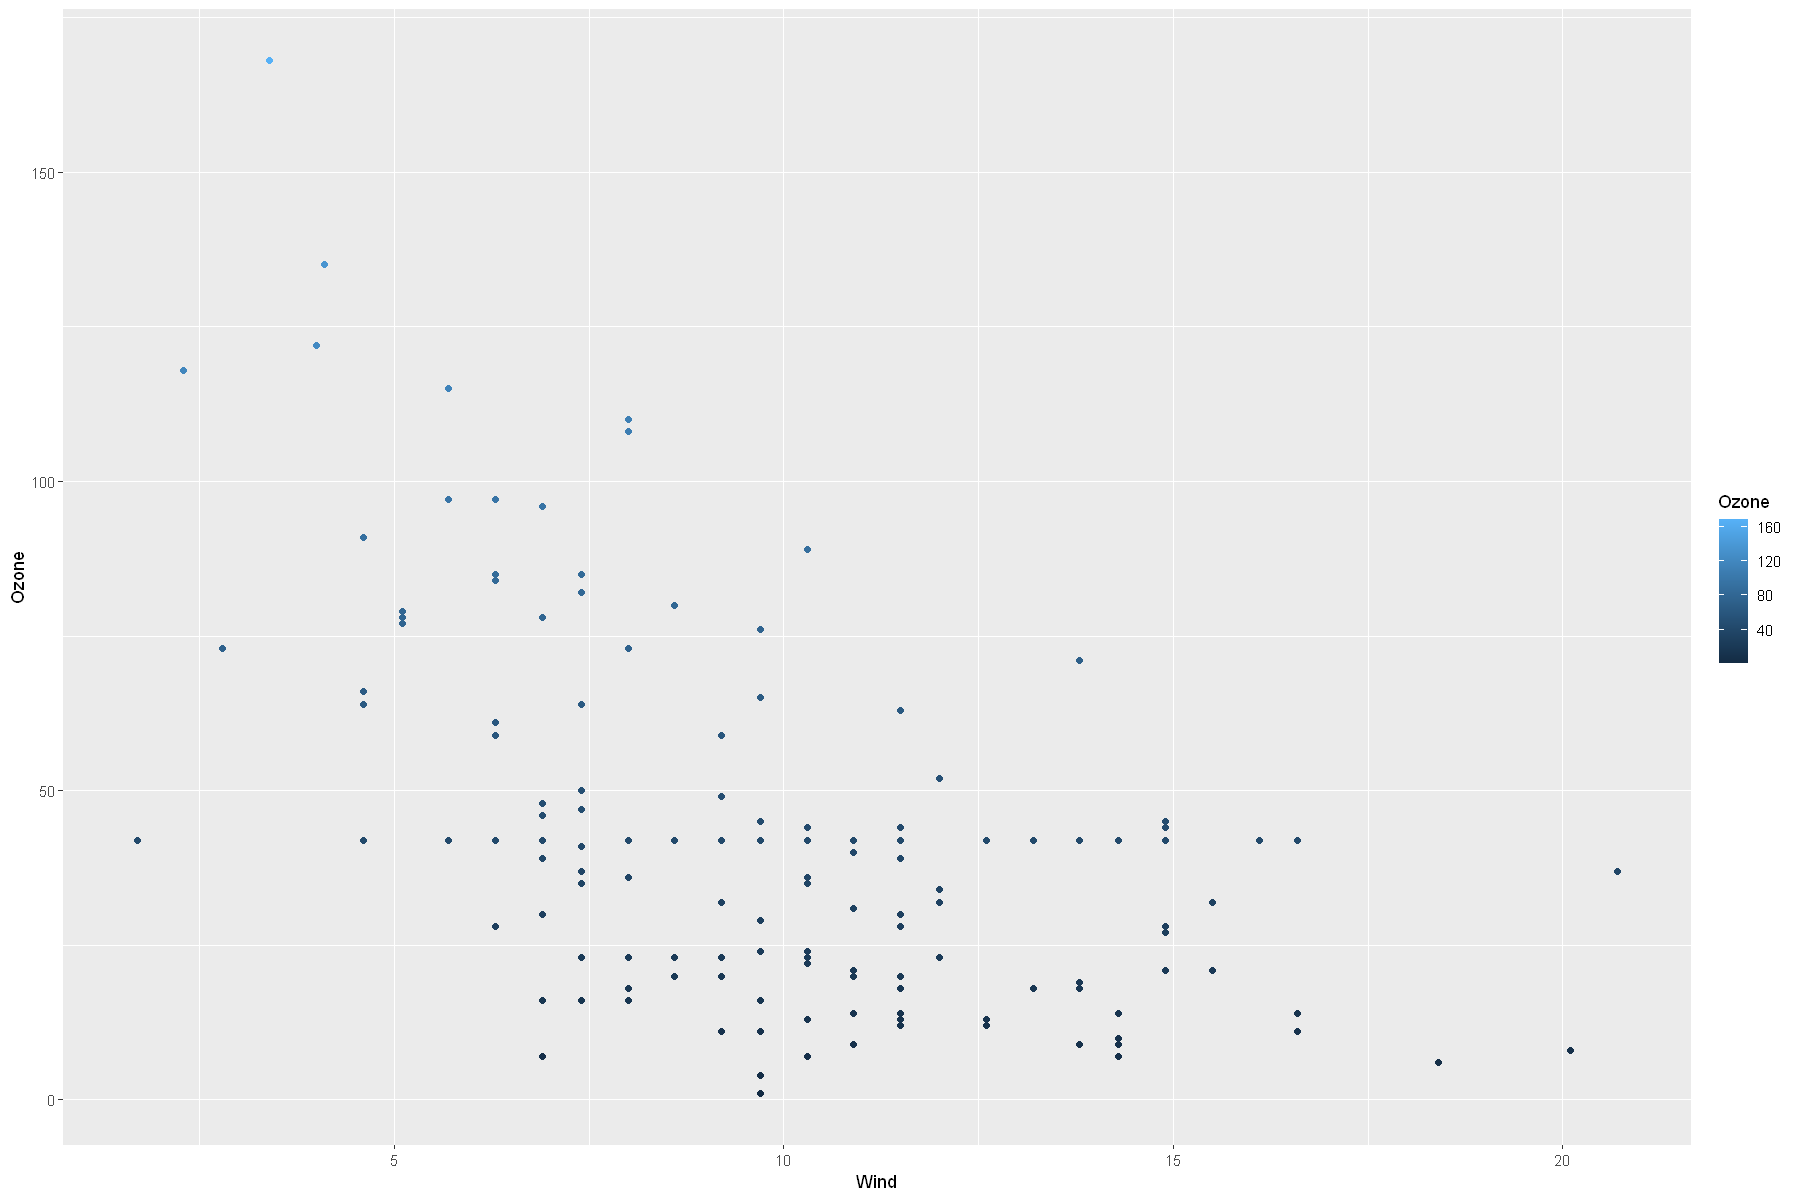

In [16]:
ggplot(df_clean,aes(Wind,Ozone)) +
    geom_point(aes(colour=Ozone))

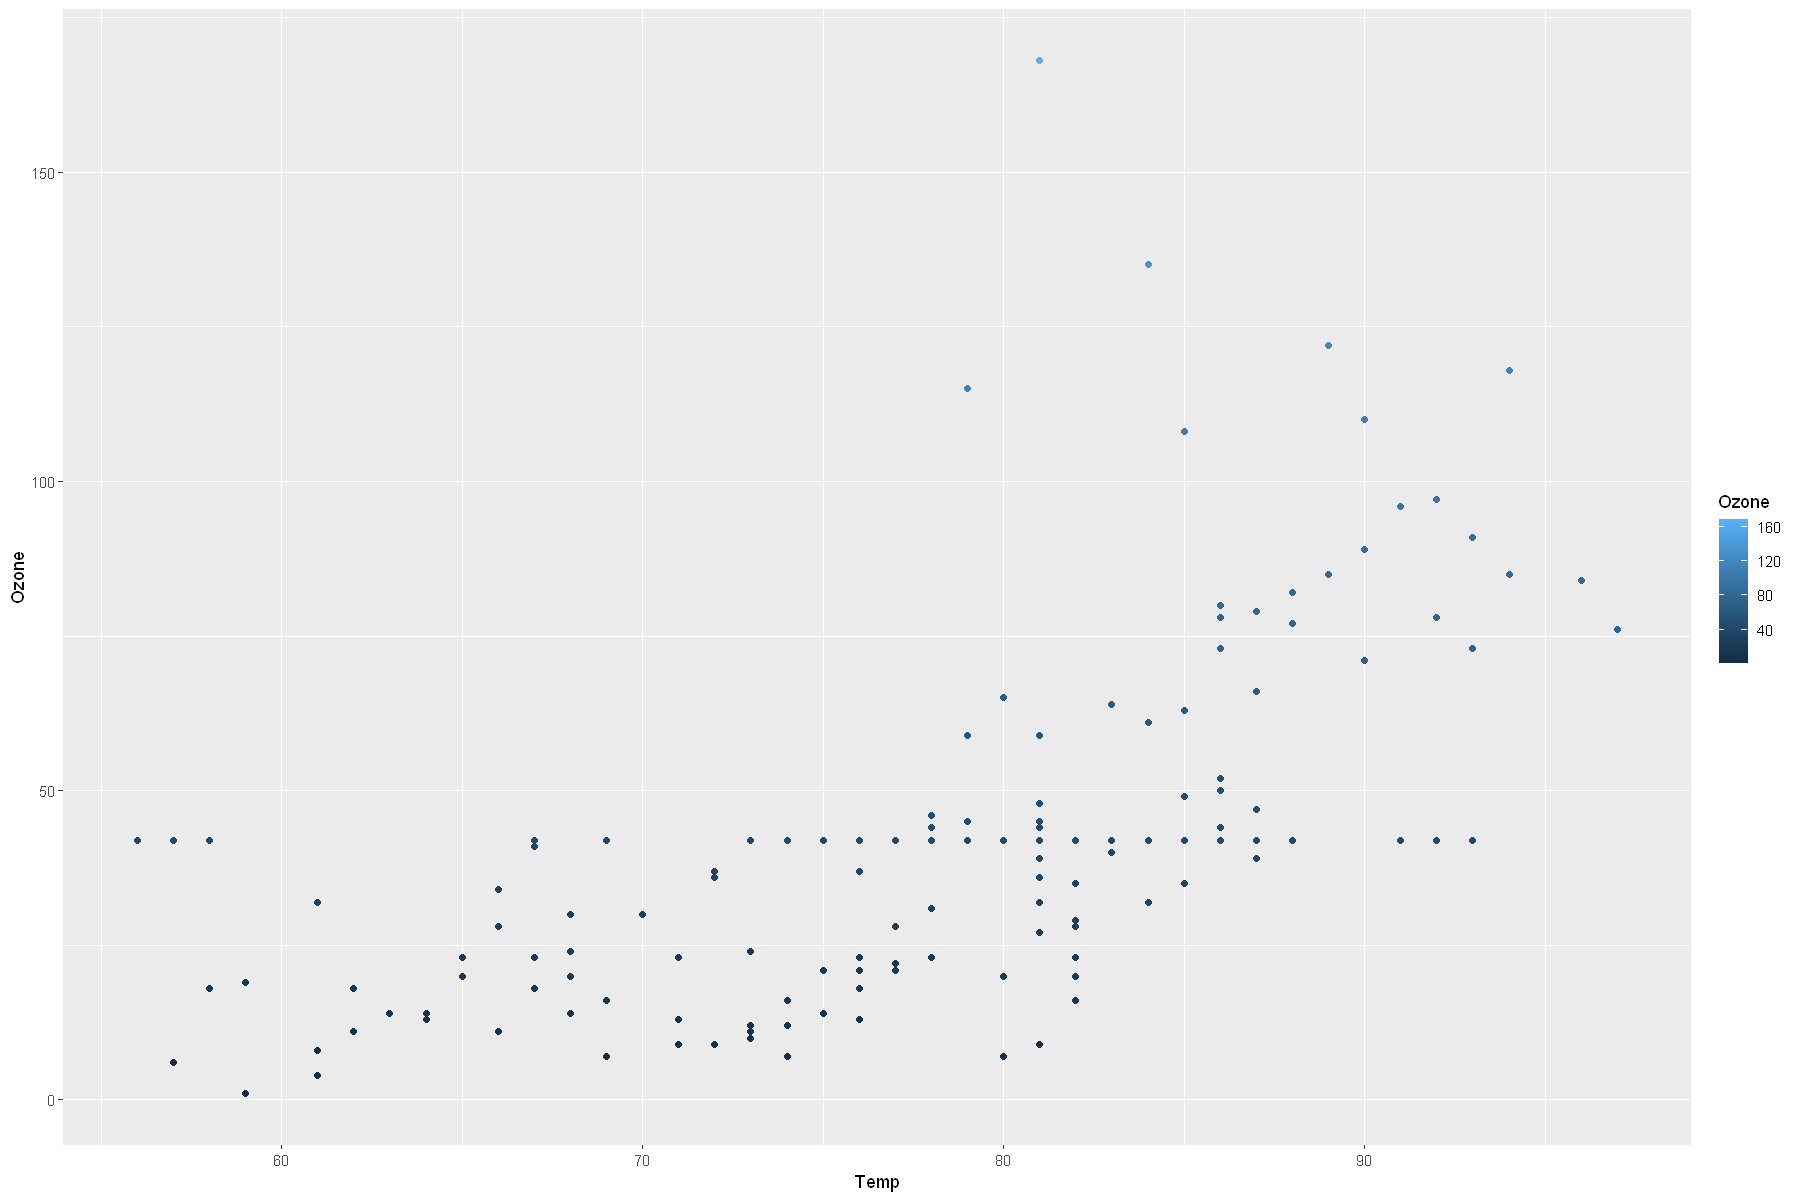

In [17]:
ggplot(df_clean,aes(Temp,Ozone)) +
    geom_point(aes(colour=Ozone))

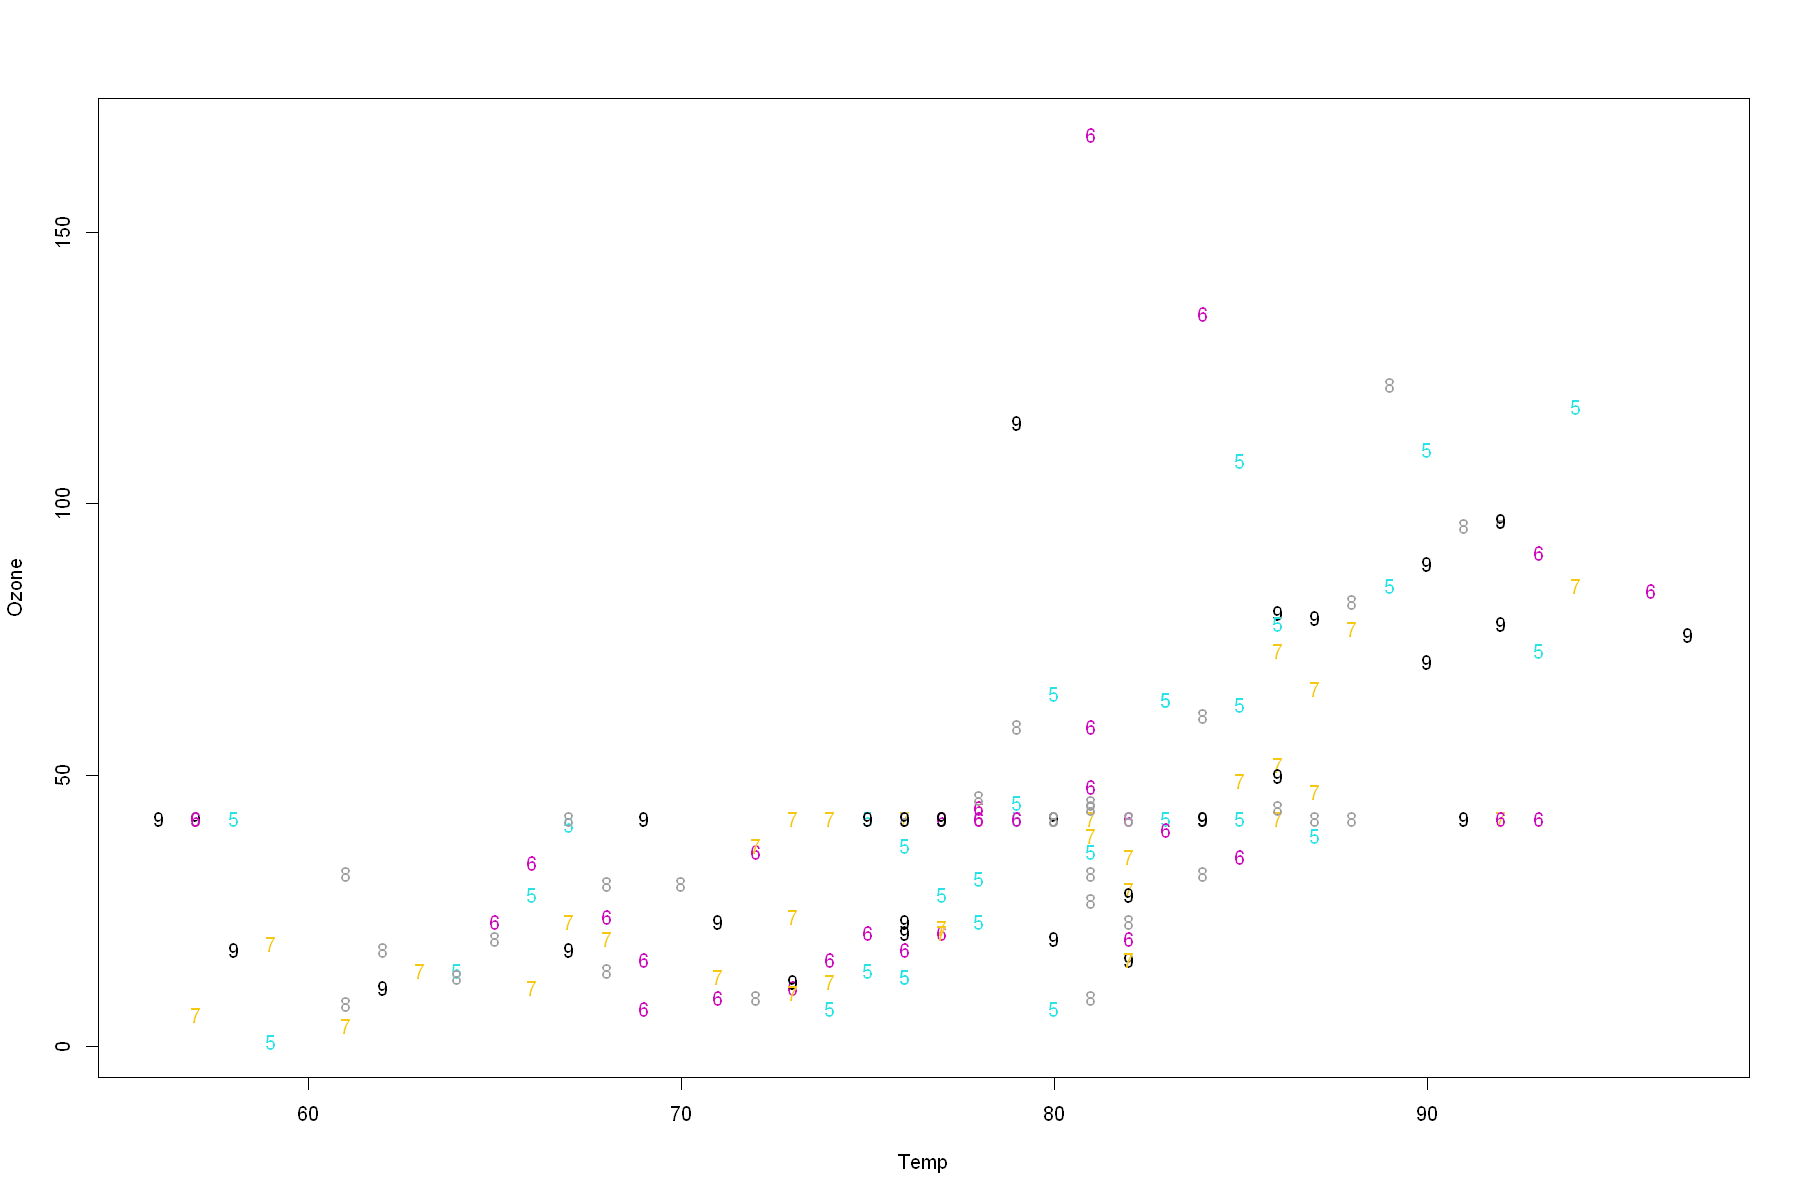

In [18]:
mlev <- levels(with(df_clean, as.factor(Month)))
with(df_clean, plot(Ozone ~ Temp, 
                      pch = mlev, 
                      col = mlev))

`geom_smooth()` using formula = 'y ~ x'


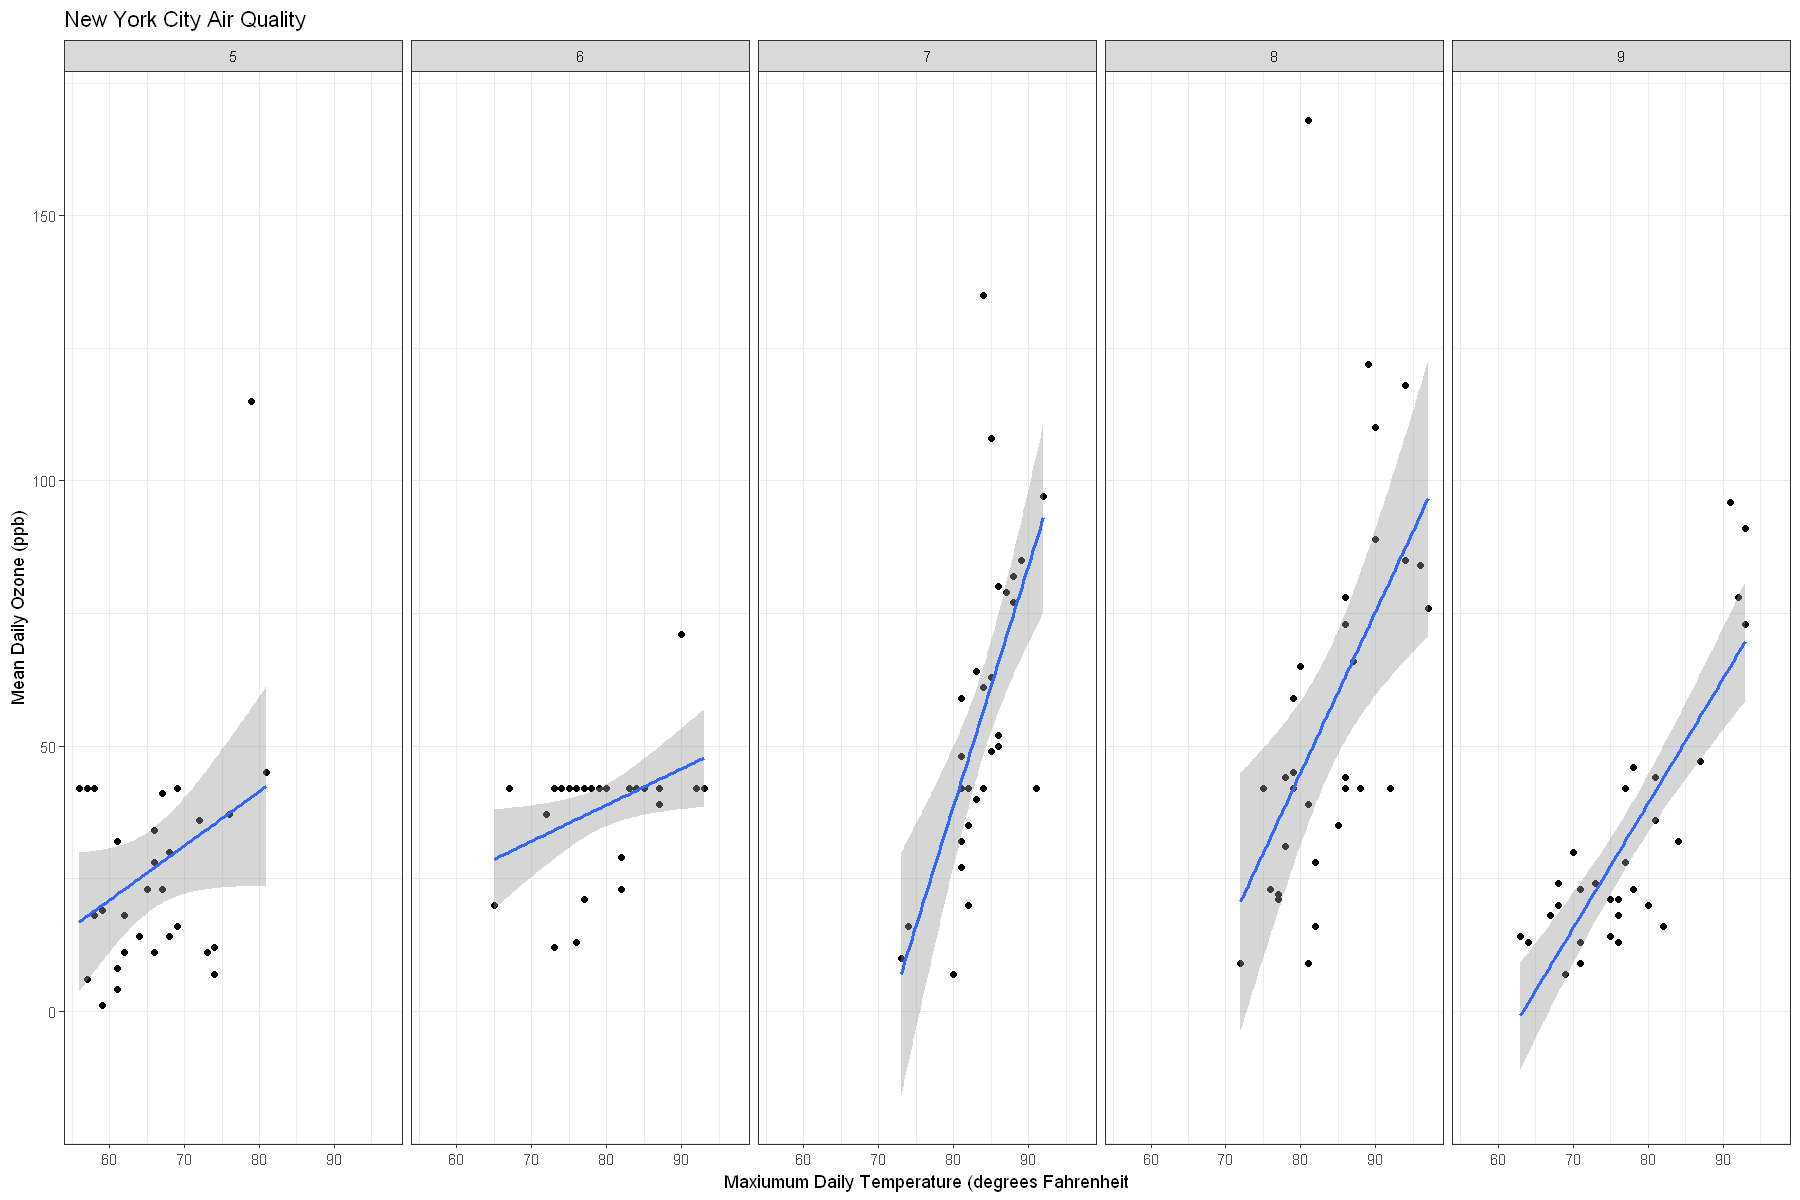

In [19]:
# https://unc-libraries-data.github.io/R-Open-Labs/week1_Introduction/R_OpenLabs_Introduction.html#facets

ggplot(df_clean, aes(x=Temp, y=Ozone)) + 
    geom_point() + 
    geom_smooth(method = "lm") + 
    facet_grid(. ~ Month) + 
    xlab("Maxiumum Daily Temperature (degrees Fahrenheit") + 
    ylab("Mean Daily Ozone (ppb)") + 
    ggtitle("New York City Air Quality") + 
    theme_bw()

In [20]:
if (!require(GGally)) install.packages('GGally') # an extension of the ggplot2 package
suppressWarnings(suppressMessages(library("GGally")))

Loading required package: GGally

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



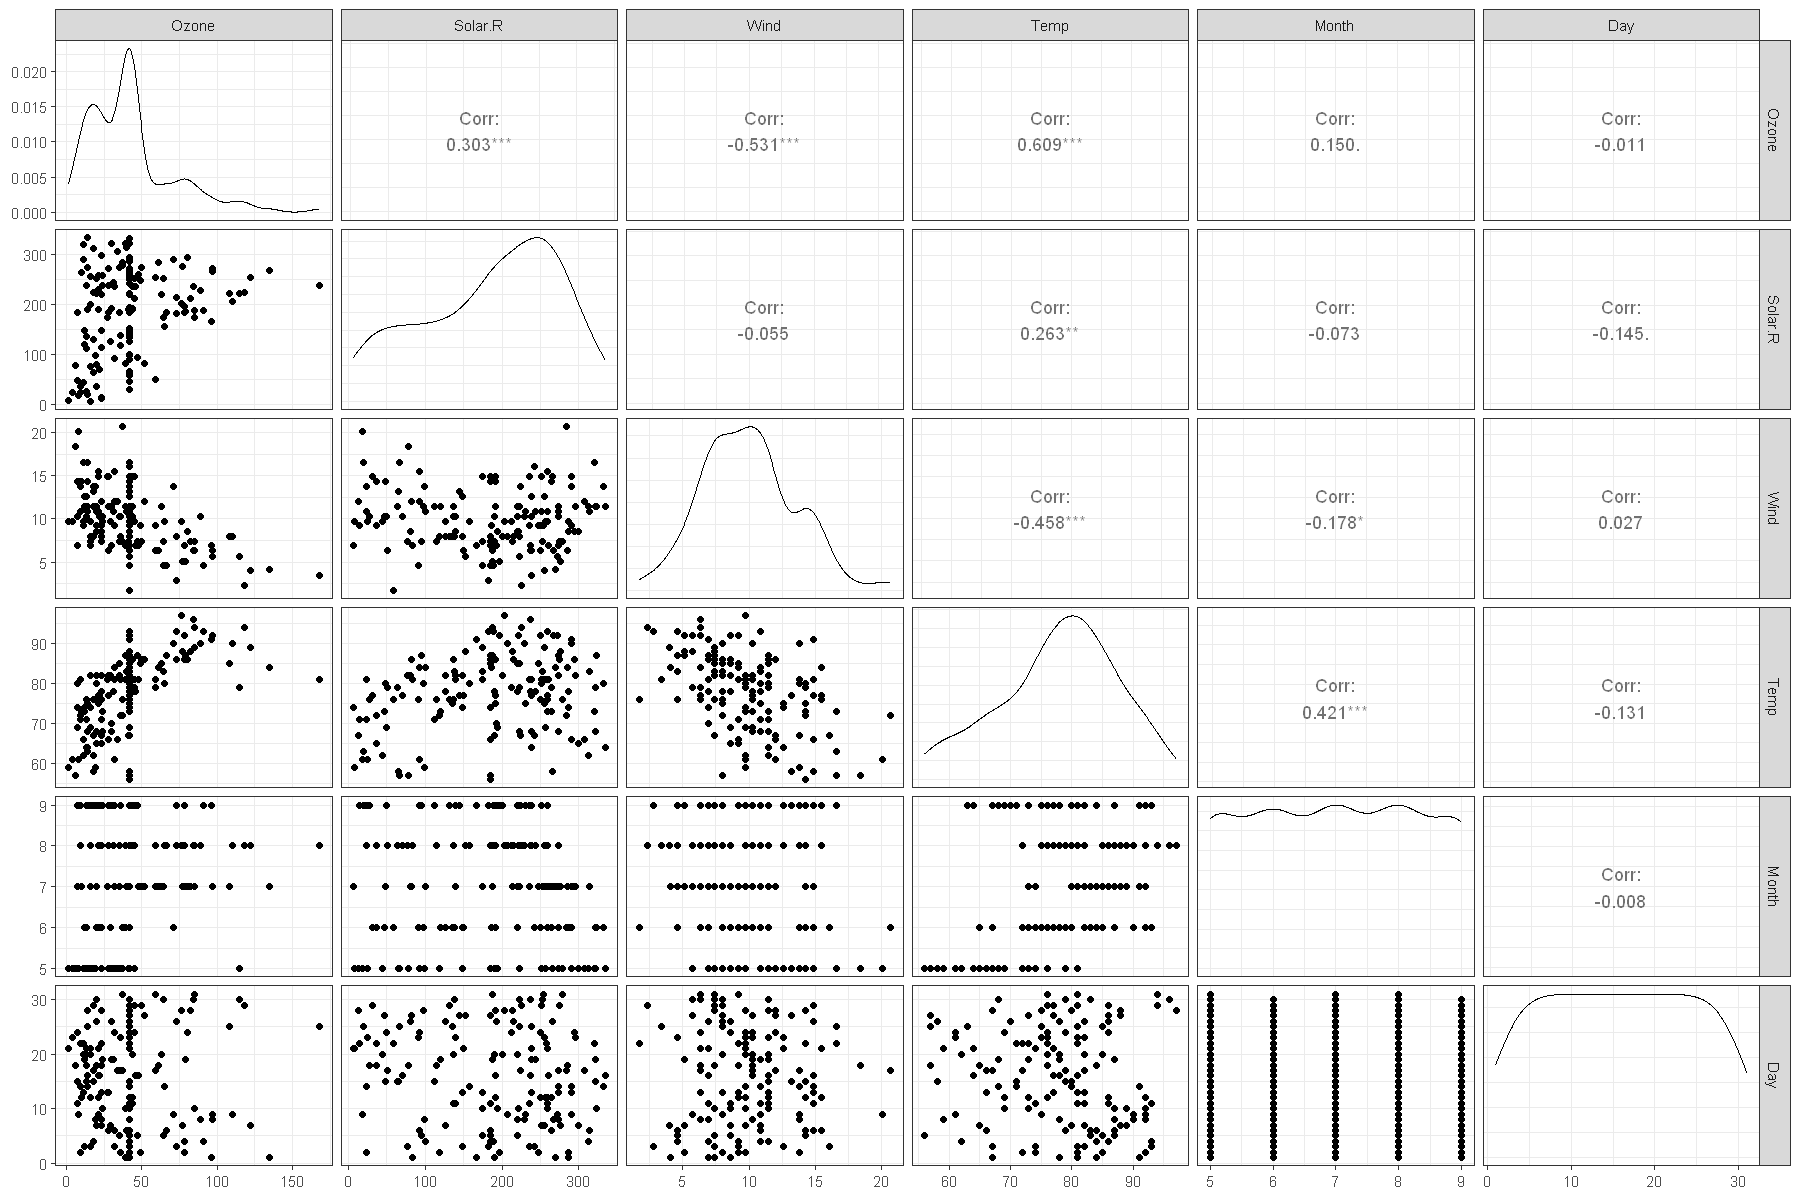

In [21]:
# plot corr matrix
df_clean %>% 
     ggpairs()  + 
     theme_bw()

`geom_smooth()` using formula = 'y ~ x'


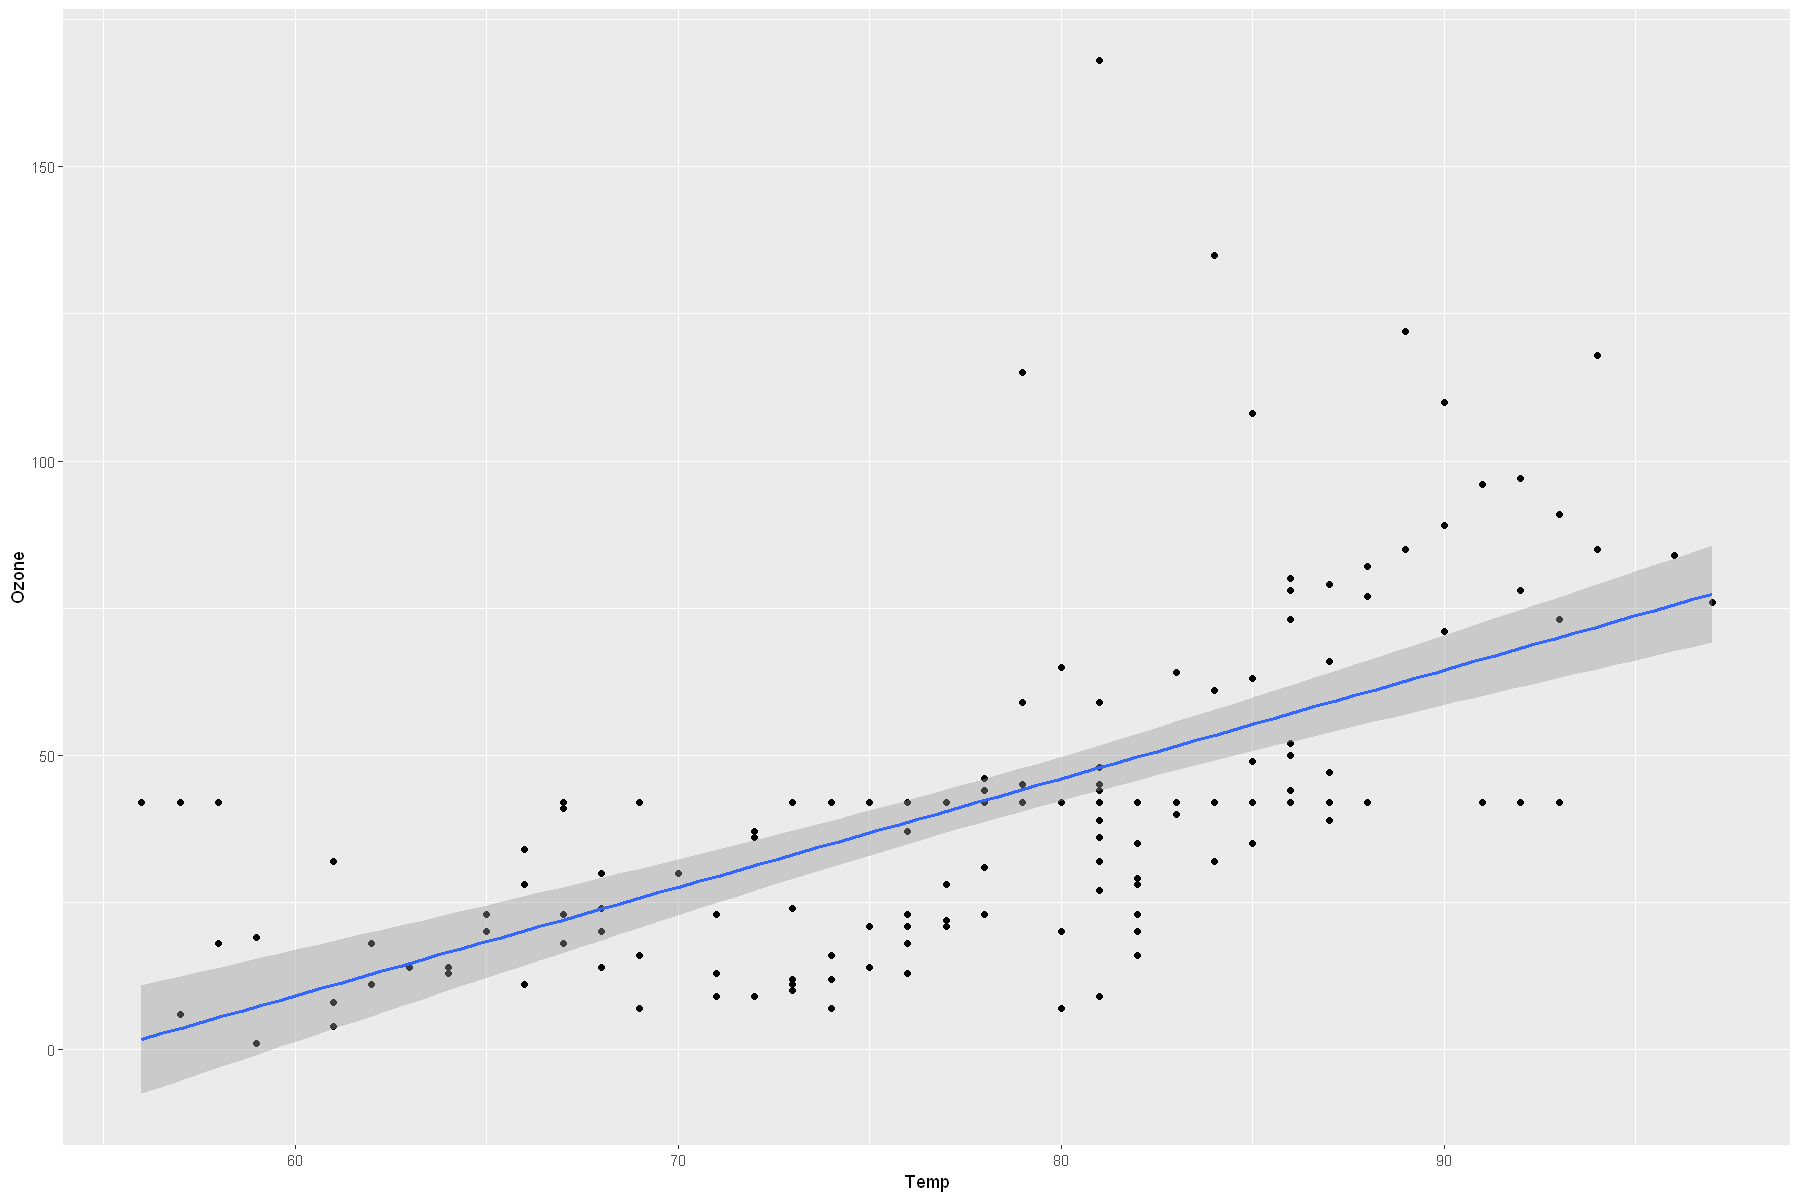

In [22]:
ggplot(df_clean, aes(x = Temp, y = Ozone)) + 
  geom_point() + geom_smooth(method="lm")  # add a best fit linear regression line

`geom_smooth()` using formula = 'y ~ x'


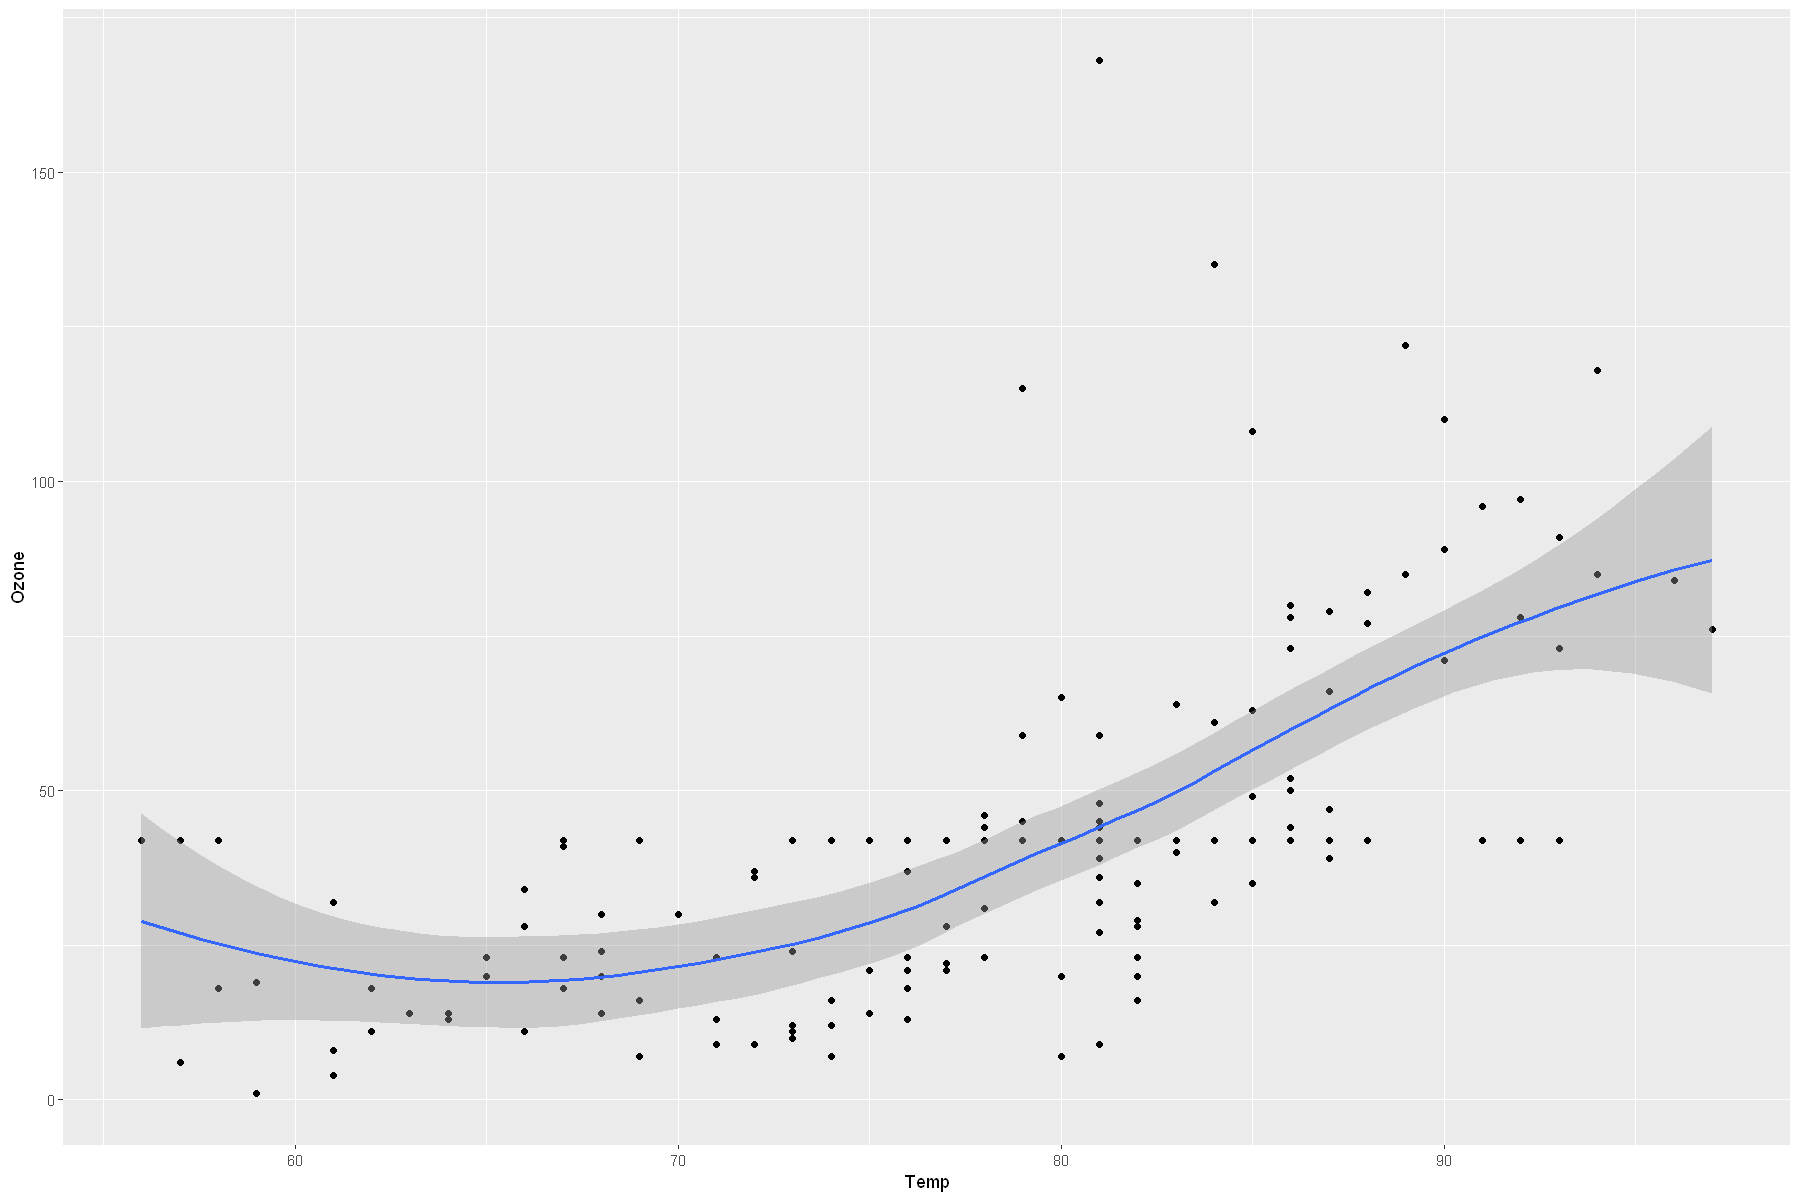

In [23]:
ggplot(df_clean, aes(x = Temp, y = Ozone)) + 
  geom_point() + geom_smooth(method="loess")  # locally-weighted version of linear regression

### Simple Linear Regression

In [24]:
##spliting the dataset on 80-20.
set.seed(1)
row.number <- sample(1:nrow(df_clean), 0.8*nrow(df_clean))
train = df_clean[row.number,]
test = df_clean[-row.number,]
dim(train)
dim(test)

[1] 122   6

[1] 31  6

####  It can be seen that training dataset has 153 observations and testing dataset has 31 observations based on 80-20 split.

### Model 1:  all variables

In [25]:
options(repr.plot.width = 15, repr.plot.height = 10)


Call:
lm(formula = Ozone ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.533 -12.443  -3.068   9.472 101.708 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -56.11827   20.23674  -2.773  0.00647 ** 
Solar.R       0.04542    0.02186   2.078  0.03992 *  
Wind         -2.36026    0.56141  -4.204 5.18e-05 ***
Temp          1.48032    0.23620   6.267 6.48e-09 ***
Month        -1.44532    1.36683  -1.057  0.29252    
Day           0.45130    0.20777   2.172  0.03189 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 19.51 on 116 degrees of freedom
Multiple R-squared:  0.502,	Adjusted R-squared:  0.4806 
F-statistic: 23.39 on 5 and 116 DF,  p-value: 3.422e-16


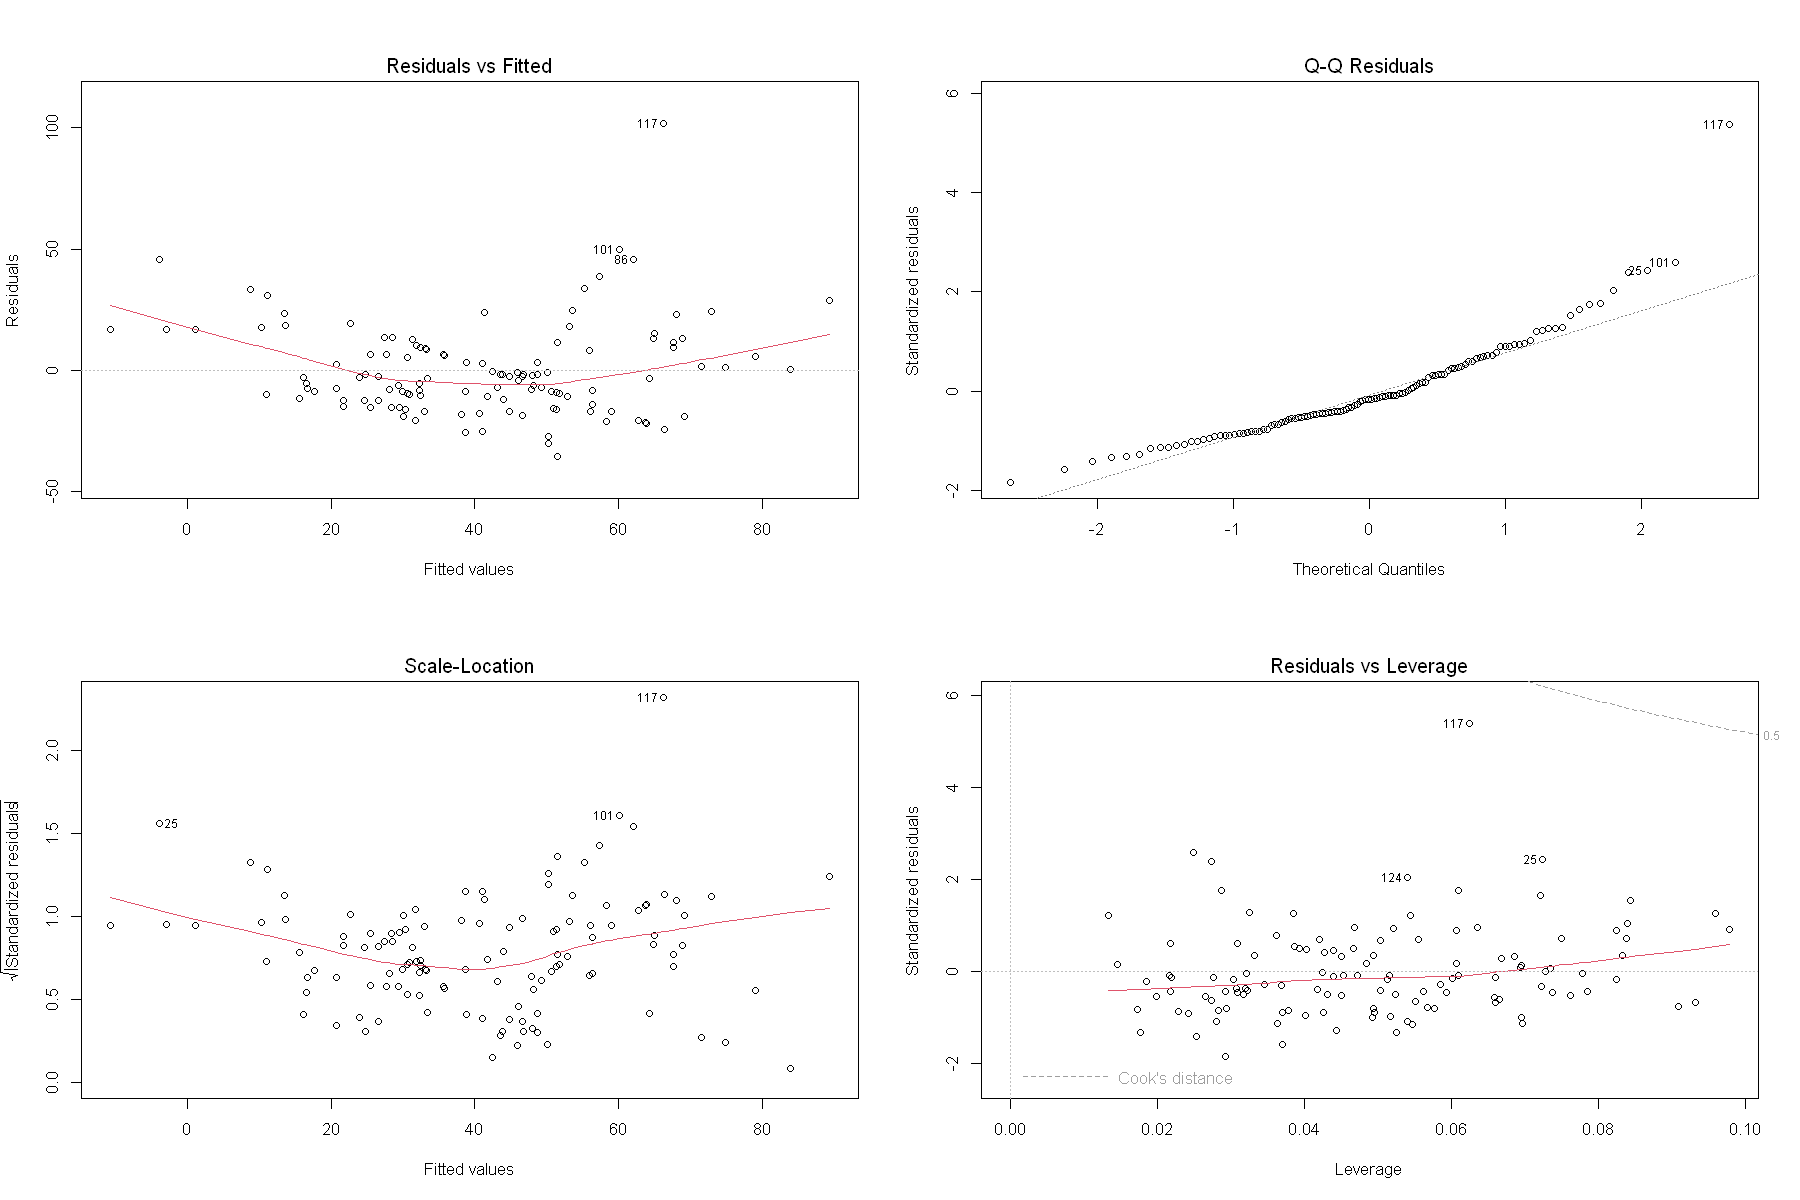

In [26]:
#Let’s make default model.
model1 = lm(Ozone~., data=train)
summary(model1)
par(mfrow=c(2,2))
plot(model1)

#### relationship between predictor and response variables
#### we obtain an F-statistic of 23.39 >1 and a p-value of 3.422e-16.
#### so we reject the null hypothesis. This indicates that at least one independent variable contributes significantly to the prediction of Ozone, and the overall regression model is statistically significant.

#### Which of the predictor variables are significant?
#### The lesser the ‘p’ value the more significant is the variable.
#### only Wind and Temp

#### Is this model fit?
#### R2 closer to 1 indicates that the model explains the large value of the variance of the model and hence a good fit. In this case, the value is 0.502 and hence the model is not quite good fit.

#### Observation from the plot:

**Fitted vs Residual graph**
    Residuals plots should be random in nature and there should not be any pattern in the graph. The average of the residual plot should be close to zero. From the above plot, we can see that the red trend line is not at zero

**Normal Q-Q Plot**
    Q-Q plot shows whether the residuals are normally distributed. Ideally, the plot should be on the dotted line. If the Q-Q plot is not on the line then models need to be reworked to make the residual normal. In the above plot, we see that most of the plots are on the line except at towards the end.

**Scale-Location**
    This shows how the residuals are spread and whether the residuals have an equal variance or not.

**Residuals vs Leverage**
    The plot helps to find influential observations. Here we need to check for points that are outside the dashed line. A point outside the dashed line will be influential point and removal of that will affect the regression coefficients.
    There is no point above dash line with 0.5 cook’s distance.

The spread of standardized residuals shouldn’t change as a function of leverage: here it appears evenly, indicating not heteroskedasticity.

### Model 2:
#### Remove outliers using Cook's Distance with selected predictors

In [27]:
# Calculate Cook's distance
cooksd <- cooks.distance(model1)

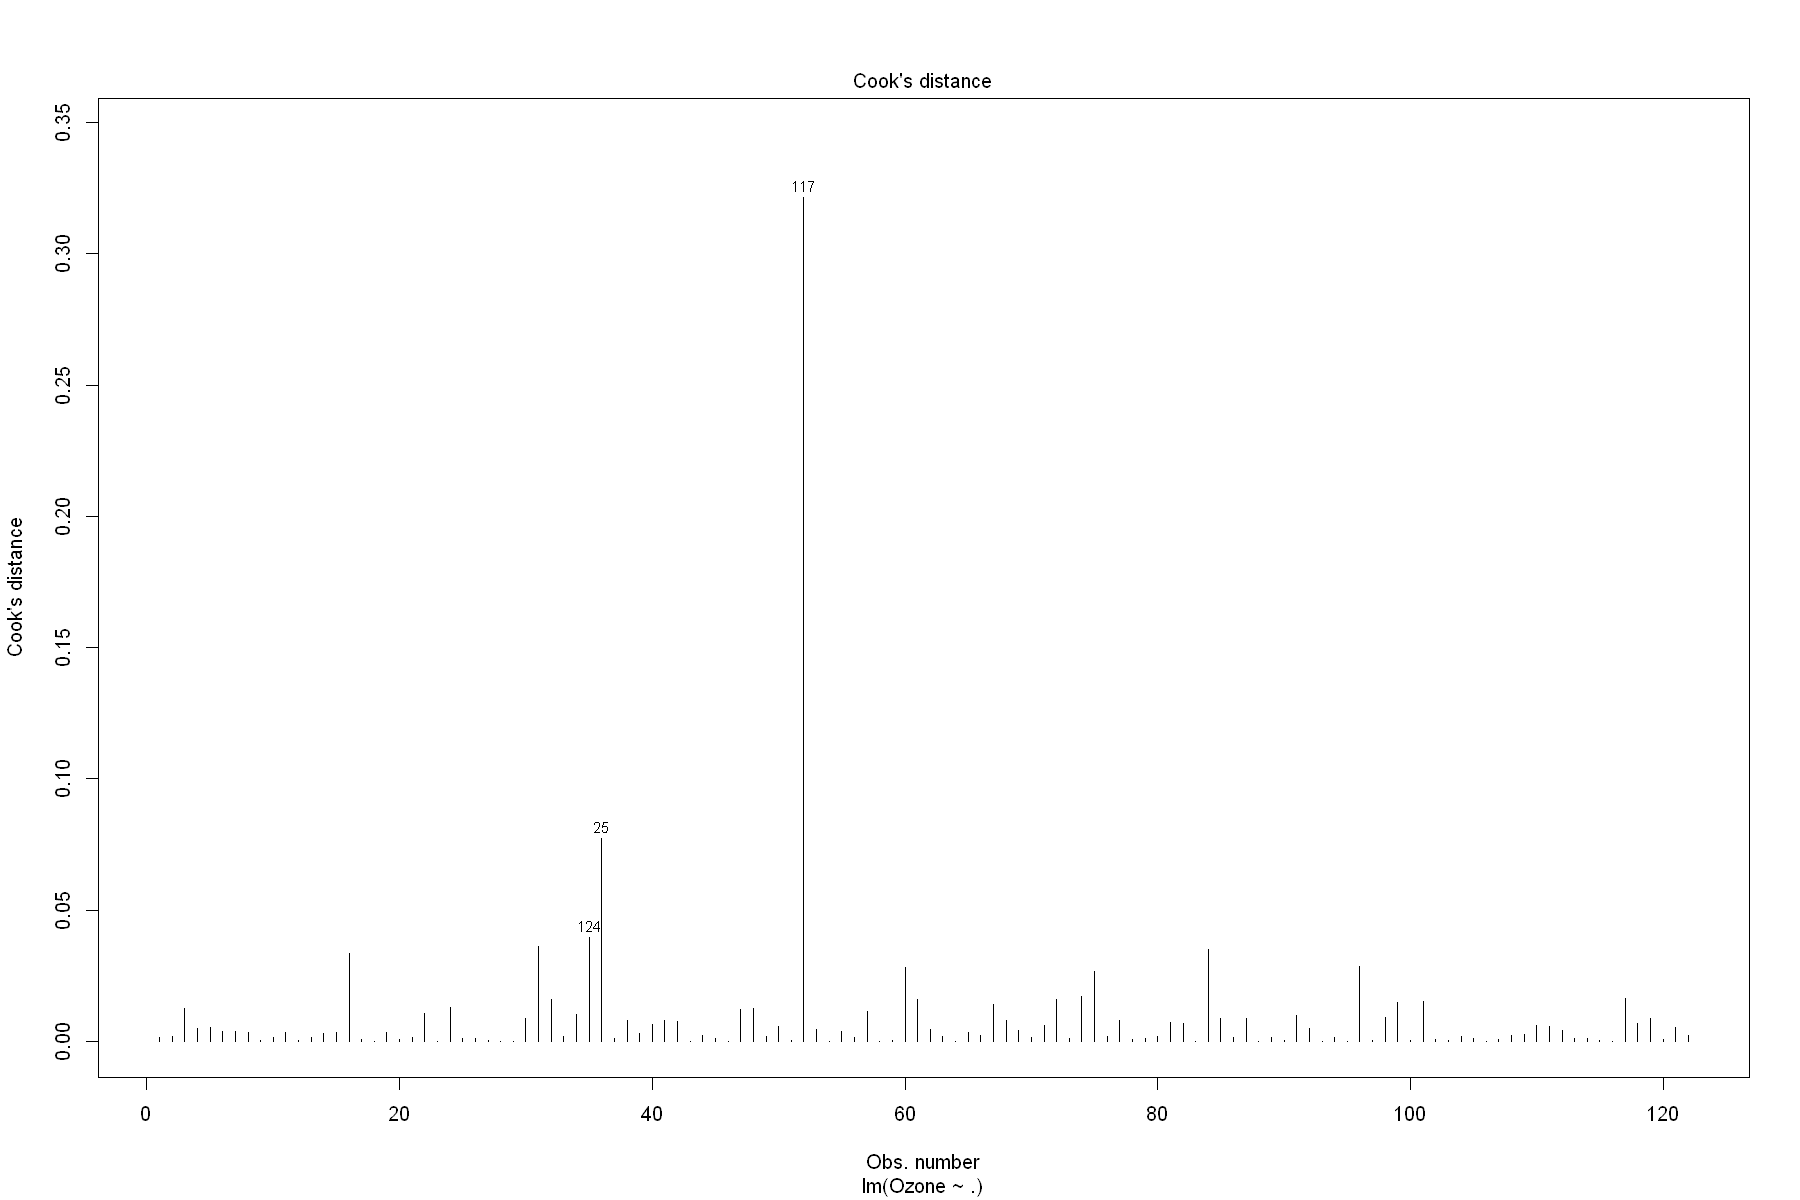

In [28]:
plot(model1,which=4)

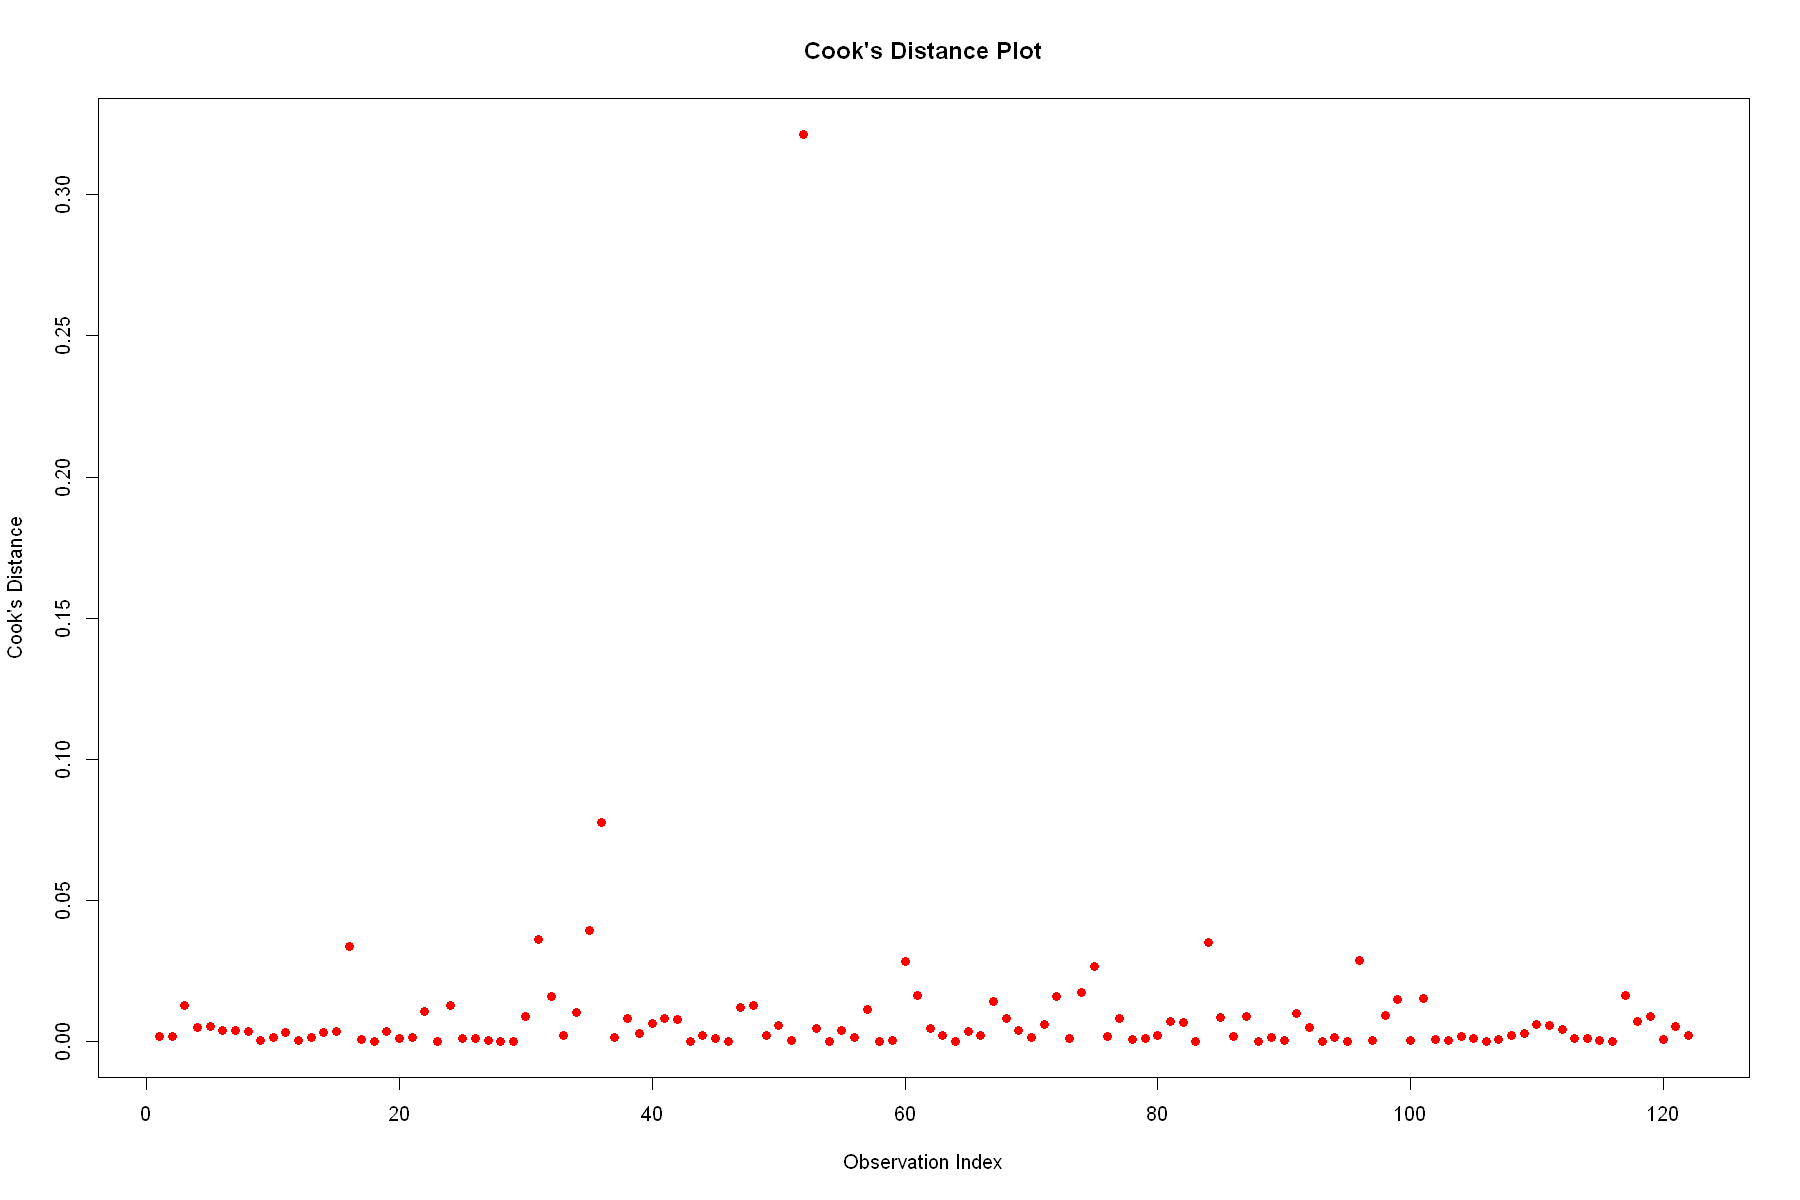

In [29]:
# Identify and visualize outliers using Cook's distance
# https://rpubs.com/DragonflyStats/Cooks-Distance
# A common rule of thumb is that an observation with a value of Cook’s D over 1.0 has too much influence.
outliers <- which(cooksd > 4 / length(cooksd))  # Adjust the threshold as needed
plot(cooksd, main = "Cook's Distance Plot", 
     ylab = "Cook's Distance", 
     xlab = "Observation Index", 
     pch = 19, 
     col = ifelse(outliers, 'red', 'black'))

In [30]:
# Remove outliers from the dataset
clean_air_quality <- df_clean[-outliers, ]

In [31]:
dim(clean_air_quality)

[1] 147   6

In [32]:
# data standardisation 

set.seed(321)
scaled_data <- clean_air_quality %>%
    mutate_at(vars("Solar.R", "Wind", "Temp", "Month", "Day"), scale)


In [33]:
##spliting the dataset on 80-20.
set.seed(1)
row.number <- sample(1:nrow(scaled_data), 0.8*nrow(scaled_data))
scaled_train = scaled_data[row.number,]
scaled_test = scaled_data[-row.number,]
dim(scaled_train)
dim(scaled_test)

[1] 117   6

[1] 30  6

In [34]:
# Re-run the regression model with the cleaned data
model2 <- lm(Ozone ~ Wind + Temp, data = scaled_train)

# Summary of the cleaned model
summary(model2)


Call:
lm(formula = Ozone ~ Wind + Temp, data = scaled_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-37.981 -14.761  -4.207  10.568 104.911 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   41.446      1.982  20.912  < 2e-16 ***
Wind          -9.365      2.292  -4.085 8.21e-05 ***
Temp          13.272      2.207   6.014 2.23e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 21.44 on 114 degrees of freedom
Multiple R-squared:  0.4474,	Adjusted R-squared:  0.4377 
F-statistic: 46.15 on 2 and 114 DF,  p-value: 2.076e-15


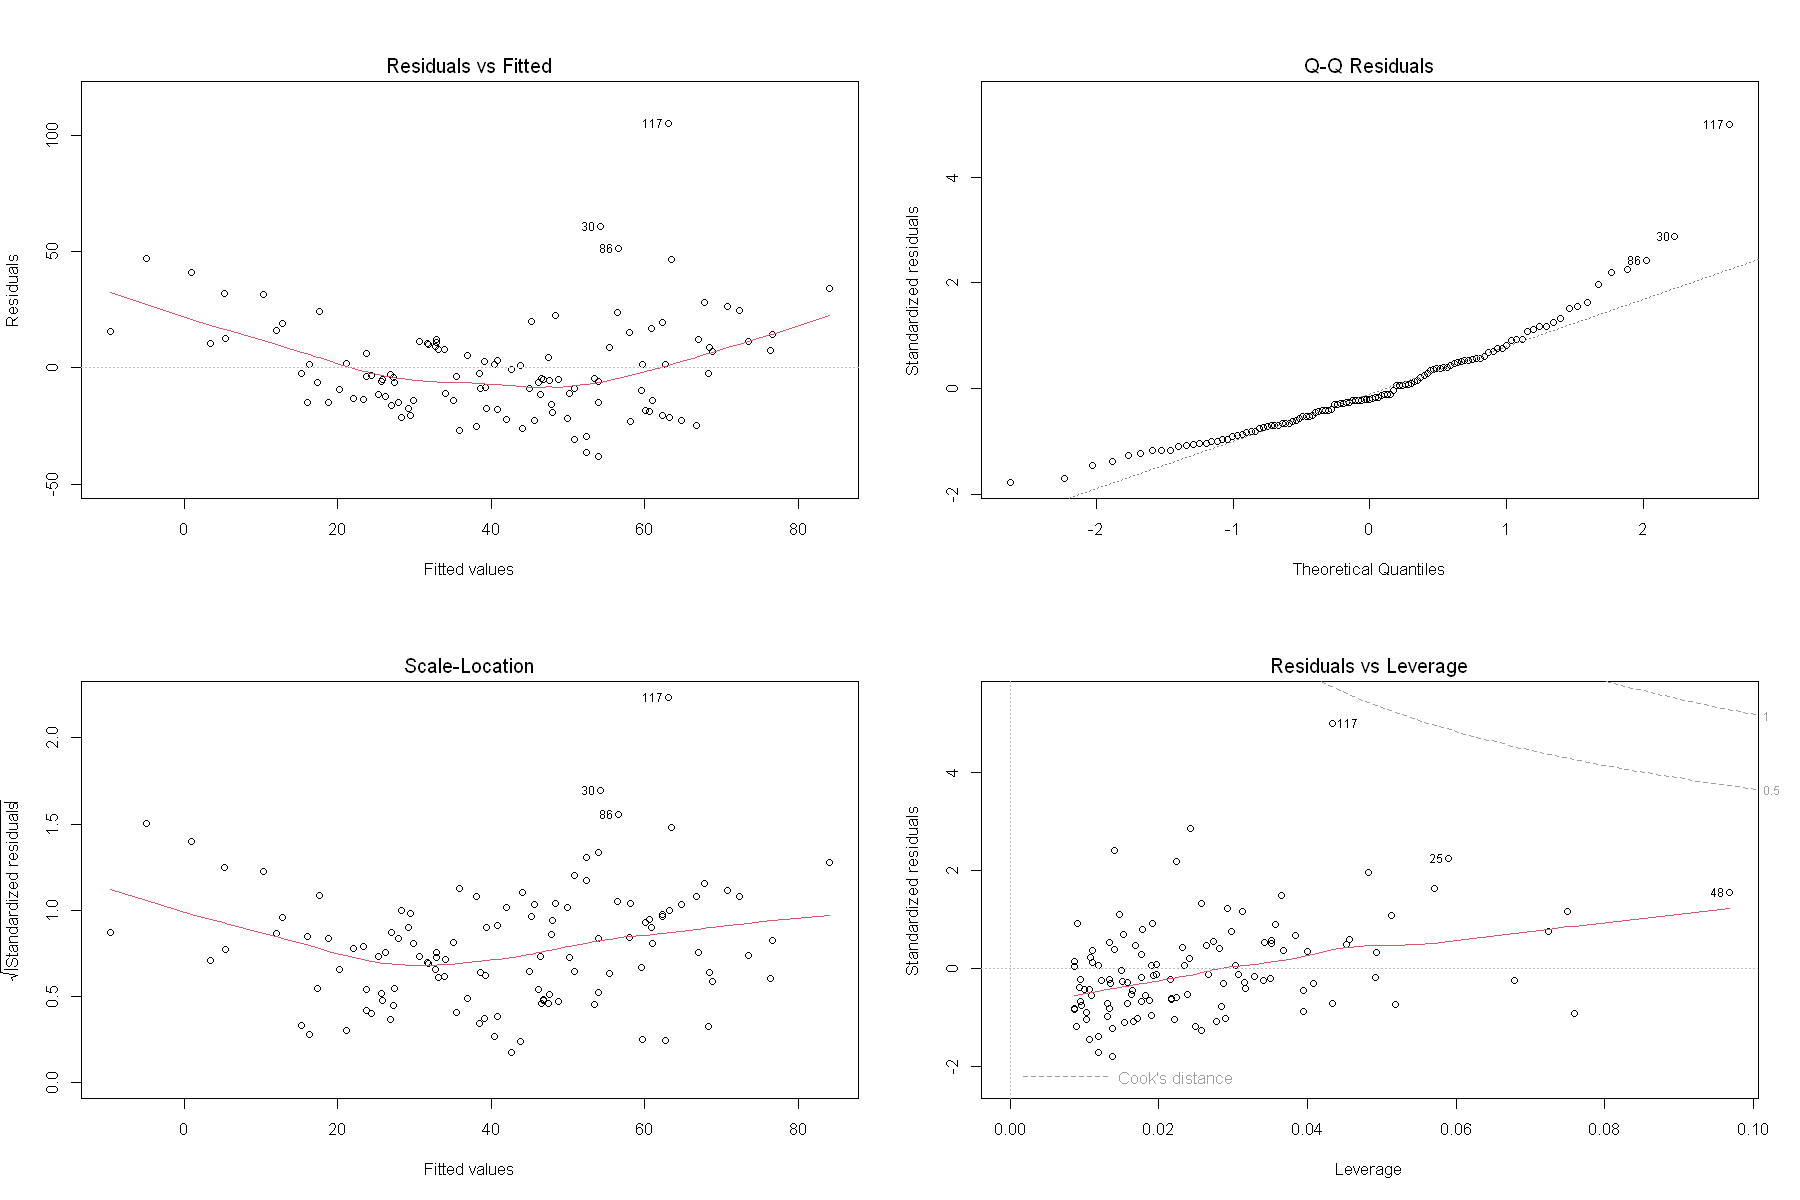

In [35]:
options(repr.plot.width = 15, repr.plot.height = 10)
par(mfrow=c(2,2))
plot(model2)

    This F value (46.75) more than the F value of the previous model. It can be concluded that there is a relationship between predictor and response variable.

    R2 has decreased a little from the first model but this should be fine as removing three predictors caused a drop from 0.502 to 0.496 and this is a small drop.

In [36]:
# https://r-graph-gallery.com/261-multiple-graphs-on-same-page.html
if (!require(gridExtra)) install.packages('gridExtra') 
suppressWarnings((library(gridExtra) ))

Loading required package: gridExtra


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




[1] "gridExtra" "GGally"    "psych"     "caret"     "lattice"   "lubridate"
 [7] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
[13] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[19] "utils"     "datasets"  "methods"   "base"

In [37]:
options(repr.plot.width = 10, repr.plot.height = 5)

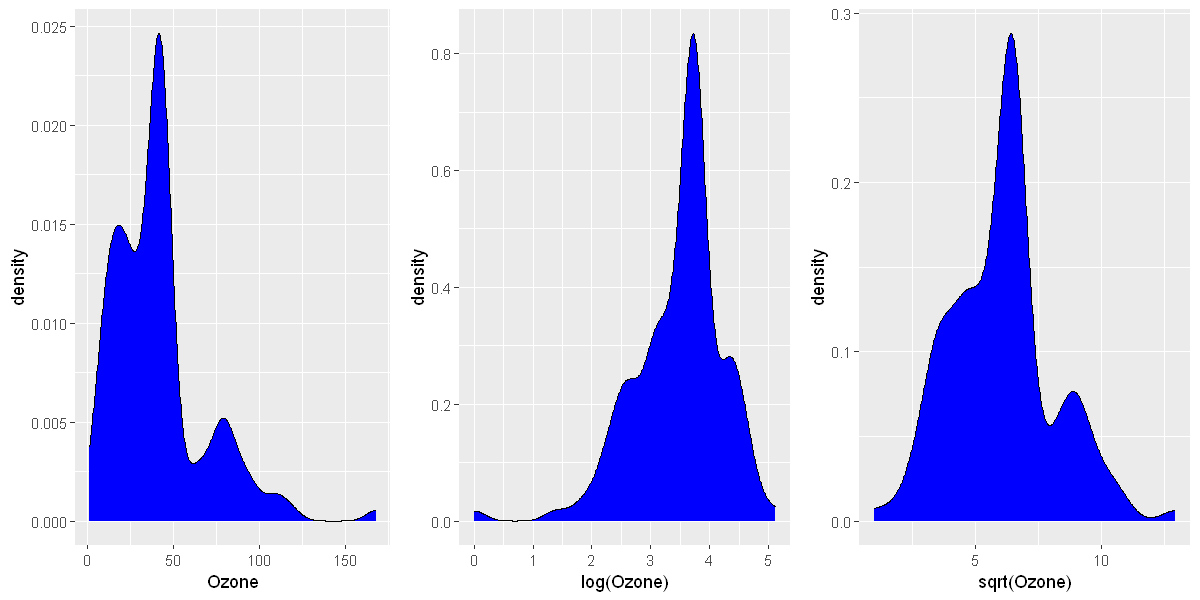

In [38]:
##Explore the response data.
g1 <- ggplot(train, aes(Ozone)) + geom_density(fill="blue")
g2 <- ggplot(train, aes(log(Ozone))) + geom_density(fill="blue")
g3 <- ggplot(train, aes(sqrt(Ozone))) + geom_density(fill="blue")

grid.arrange(g1, g2, g3, ncol = 3)


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


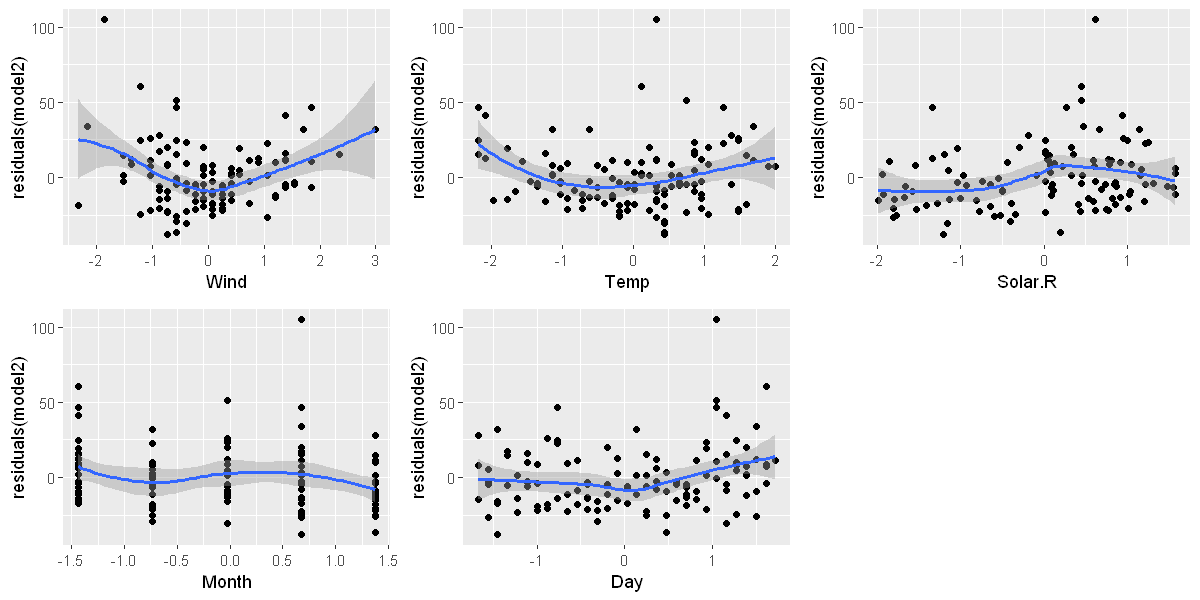

In [39]:
# Check for predictor vs Residual Plot

plot1 = ggplot(scaled_train, aes(Wind, residuals(model2))) + geom_point() + geom_smooth()
plot2= ggplot(scaled_train, aes(Temp, residuals(model2))) + geom_point() + geom_smooth()
plot3 = ggplot(scaled_train, aes(Solar.R, residuals(model2))) + geom_point() + geom_smooth()
plot4= ggplot(scaled_train, aes(Month, residuals(model2))) + geom_point() + geom_smooth()
plot5 = ggplot(scaled_train, aes(Day, residuals(model2))) + geom_point() + geom_smooth()

grid.arrange(plot1,plot2,plot3,plot4,plot5,ncol=3,nrow=2)

### Model 3:
#### Transform response variable and adding a square term to check for non-linearity on predictor variables

In [40]:
#Lets  make default model and add square term in the model.
model3 = lm(sqrt(Ozone) ~ Solar.R + Wind + Temp + Month + Day +
    I(Solar.R^2)+ I(Wind^2)+I(Temp^2)+ I(Month^2)+ I(Day^2) , data=scaled_train)
summary(model3)


Call:
lm(formula = sqrt(Ozone) ~ Solar.R + Wind + Temp + Month + Day + 
    I(Solar.R^2) + I(Wind^2) + I(Temp^2) + I(Month^2) + I(Day^2), 
    data = scaled_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1368 -0.9458 -0.0422  0.7525  4.1279 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.72749    0.32262  17.753  < 2e-16 ***
Solar.R       0.39983    0.14750   2.711 0.007834 ** 
Wind         -0.65004    0.14645  -4.438 2.23e-05 ***
Temp          0.81533    0.19856   4.106 7.93e-05 ***
Month        -0.15686    0.14273  -1.099 0.274270    
Day           0.22190    0.12157   1.825 0.070775 .  
I(Solar.R^2) -0.32441    0.14222  -2.281 0.024551 *  
I(Wind^2)     0.31276    0.09203   3.398 0.000956 ***
I(Temp^2)     0.26208    0.10890   2.407 0.017832 *  
I(Month^2)   -0.28843    0.19584  -1.473 0.143775    
I(Day^2)      0.38927    0.14863   2.619 0.010108 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual s

### Model 4:

In [41]:
##Removing the insignificant variables.
model4 = lm(sqrt(Ozone) ~.  - Month - Day  - I(Month^2), data=scaled_train)
summary(model4)


Call:
lm(formula = sqrt(Ozone) ~ . - Month - Day - I(Month^2), data = scaled_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9515 -1.2143 -0.1397  0.9459  5.0155 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.0730     0.1372  44.250  < 2e-16 ***
Solar.R       0.5035     0.1500   3.356  0.00108 ** 
Wind         -0.6820     0.1607  -4.244 4.51e-05 ***
Temp          0.9210     0.1635   5.632 1.32e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.484 on 113 degrees of freedom
Multiple R-squared:  0.5253,	Adjusted R-squared:  0.5127 
F-statistic: 41.68 on 3 and 113 DF,  p-value: < 2.2e-16


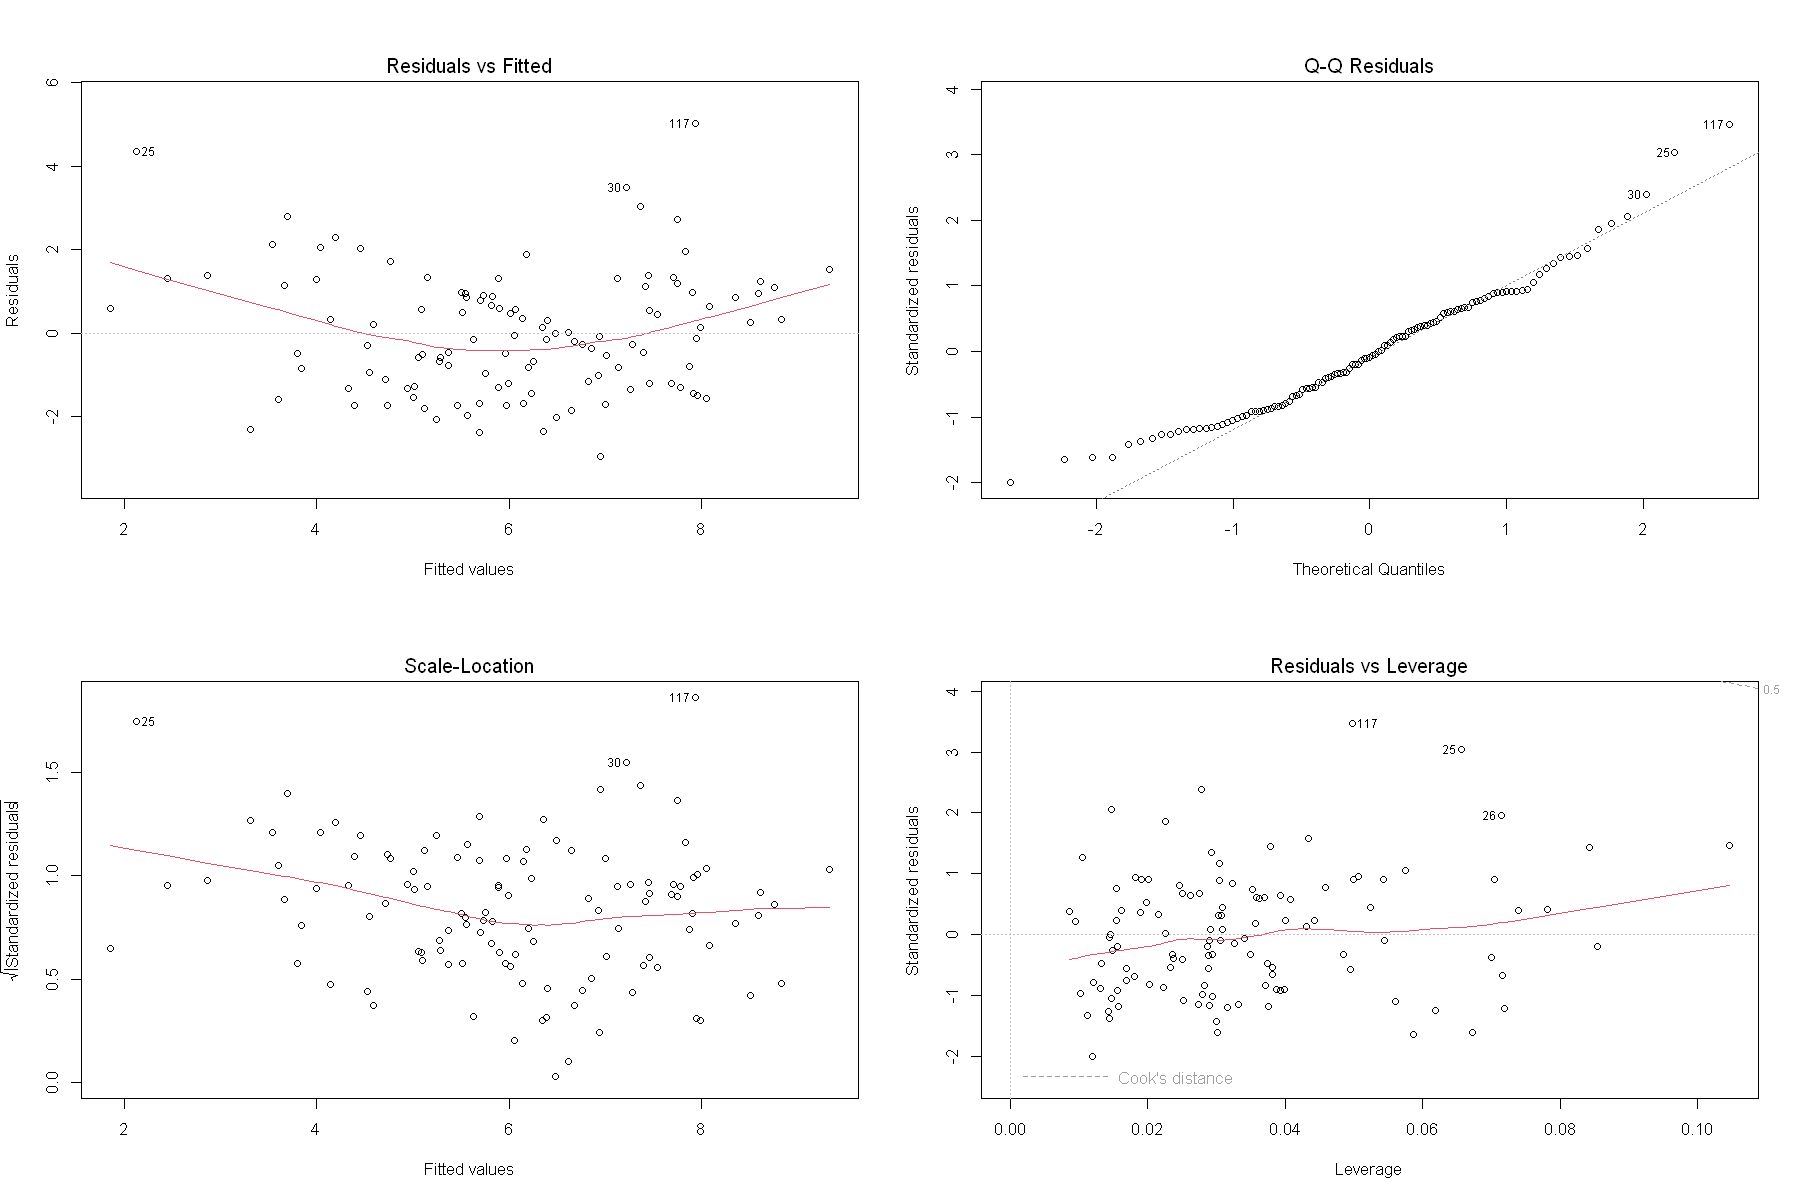

In [42]:
options(repr.plot.width = 15, repr.plot.height = 10)
par(mfrow=c(2,2))
plot(model4)

### Model 5: Further remove insignificant variables.

In [43]:
model5 <- lm(sqrt(Ozone) ~ Temp , data = scaled_train)
summary(model5)


Call:
lm(formula = sqrt(Ozone) ~ Temp, data = scaled_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5172 -1.2176 -0.0939  0.8628  6.4443 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.0694     0.1506  40.310  < 2e-16 ***
Temp          1.3695     0.1506   9.094 3.35e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.629 on 115 degrees of freedom
Multiple R-squared:  0.4183,	Adjusted R-squared:  0.4132 
F-statistic:  82.7 on 1 and 115 DF,  p-value: 3.35e-15


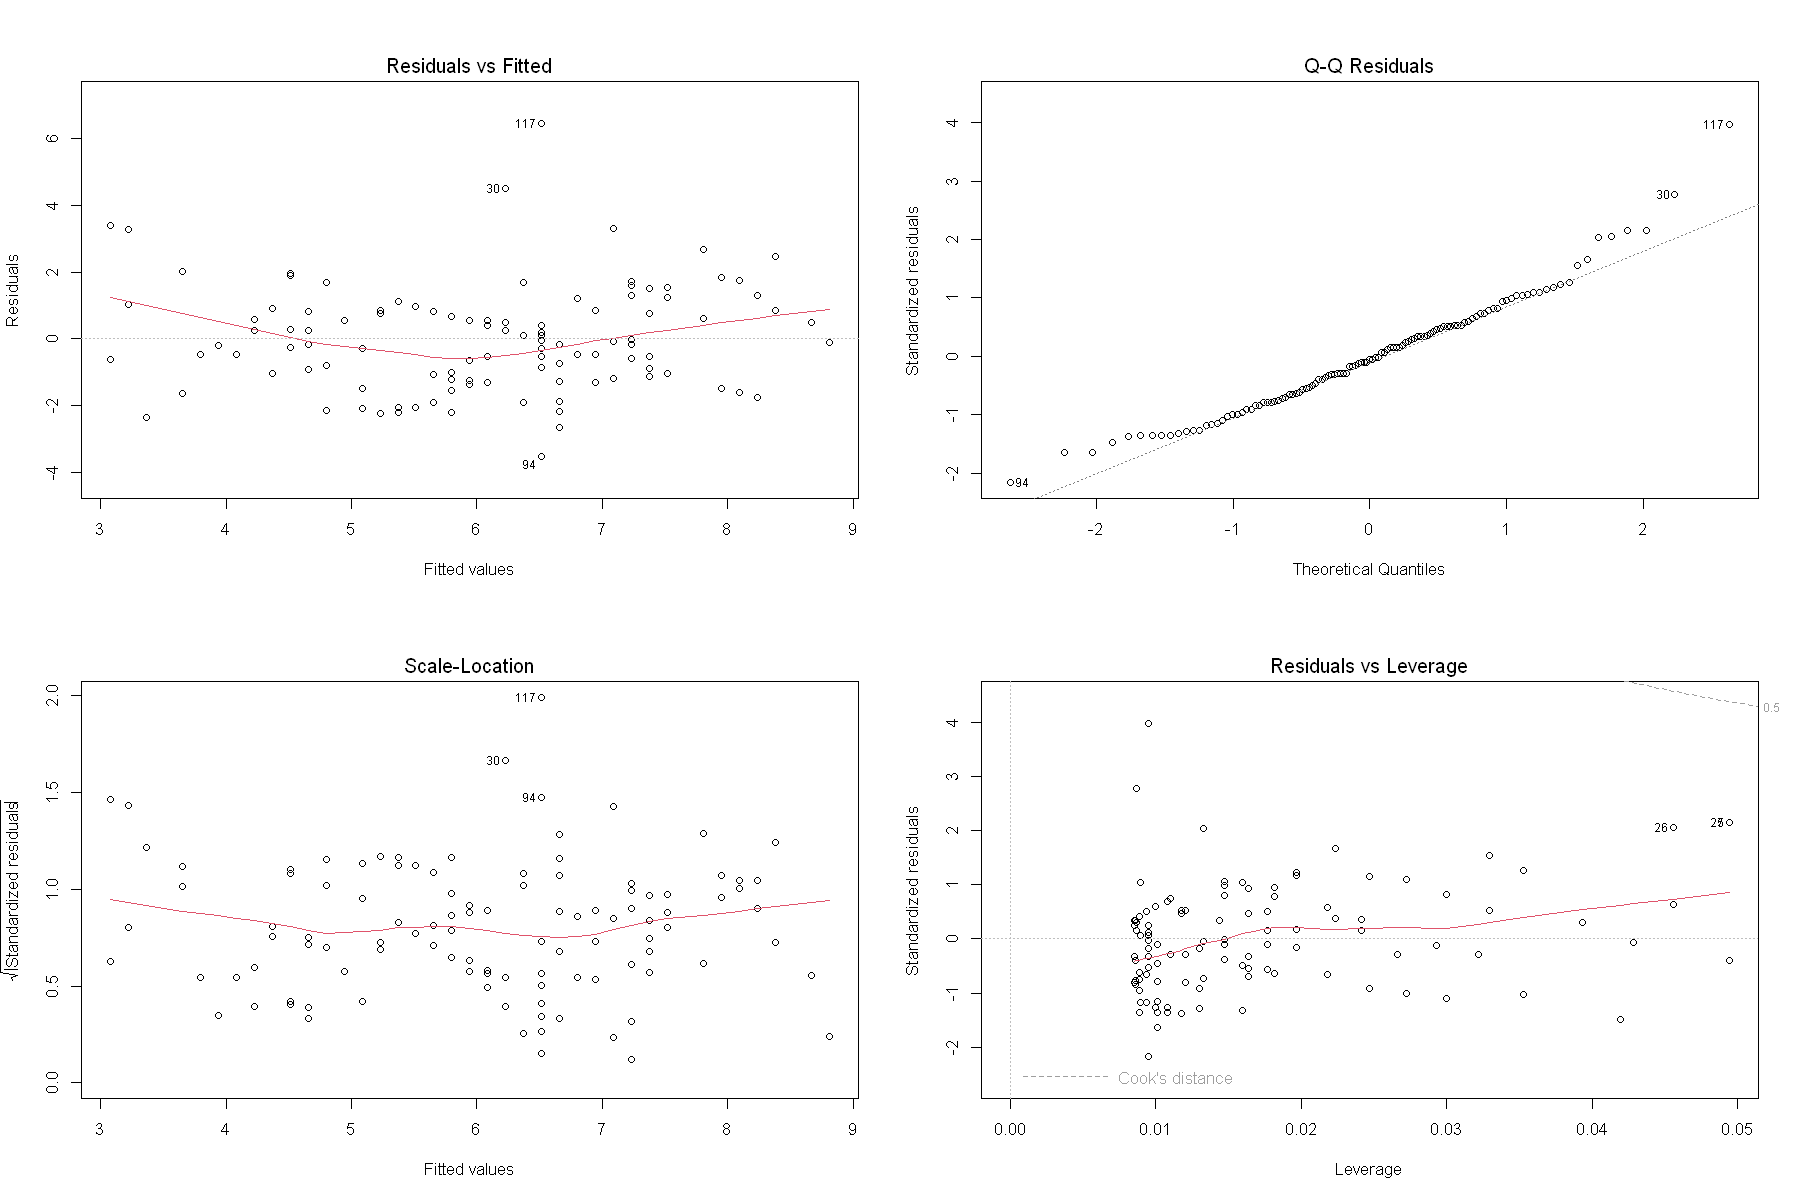

In [44]:
options(repr.plot.width = 15, repr.plot.height = 10)
par(mfrow=c(2,2))
plot(model5)

**This R2 (0.4183) lower than Model 3 (0.6755),but highest F-value (82.7) than other Models

### Prediction

In [45]:
pred1 <- predict(model1, newdata = test)
model1_rmse <- round(sqrt(sum((pred1 - test$Ozone)^2) / length(test$Ozone)), digits =4)
model1_R2 <- round(summary(model1)$r.squared, digits =4)
model1_fstat <- unname(round(summary(model1)$fstatistic[1] , digits =2) )
c1 <- c( model1_rmse, model1_R2, model1_fstat)

In [46]:
pred2 <- predict(model2, newdata = scaled_test)
model2_rmse <- round(sqrt(sum((pred2 - scaled_test$Ozone)^2) / length(scaled_test$Ozone)), digits =4)
model2_R2 <- round(summary(model2)$r.squared, digits =4)
model2_fstat <- unname(round(summary(model2)$fstatistic[1] , digits =2) )
c2 <- c( model2_rmse, model2_R2, model2_fstat)

In [47]:
pred3 <- predict(model3, newdata = scaled_test)
model3_rmse <- round(sqrt(sum((pred3^2 - scaled_test$Ozone)^2) / length(scaled_test$Ozone)), digits =4)
model3_R2 <- round(summary(model3)$r.squared, digits =4)
model3_fstat <- unname(round(summary(model3)$fstatistic[1] , digits =2) )
c3 <- c( model3_rmse, model3_R2, model3_fstat)

In [48]:
pred4 <- predict(model4, newdata = scaled_test)
model4_rmse <- round(sqrt(sum((pred4^2 - scaled_test$Ozone)^2) / length(scaled_test$Ozone)), digits =4)
model4_R2 <- round(summary(model4)$r.squared, digits =4)
model4_fstat <- unname(round(summary(model4)$fstatistic[1] , digits =2) )
c4 <- c( model4_rmse, model4_R2, model4_fstat)

In [49]:
pred5 <- predict(model5, newdata = scaled_test)
model5_rmse <- round(sqrt(sum((pred5^2 - scaled_test$Ozone)^2) / length(scaled_test$Ozone)), digits =4)
model5_R2 <- round(summary(model5)$r.squared, digits =4)
model5_fstat <- unname(round(summary(model5)$fstatistic[1] , digits =2) )
c5 <- c( model5_rmse, model5_R2, model5_fstat)

In [50]:
lst_obj <- list(model1=c1,model2=c2,model3=c3,model4=c4,model5=c5)  # declaring a list object
df <- do.call(rbind, lst_obj) # binding columns together
data_frame <- as.data.frame(df) # converting to a dataframe
colnames(data_frame) <- c("RMSE", "R-Square", "F-Stat")
 
print (data_frame)

          RMSE R-Square F-Stat
model1 25.5356   0.5020  23.39
model2 23.0491   0.4474  46.15
model3 20.0226   0.6755  22.07
model4 21.3369   0.5253  41.68
model5 24.8923   0.4183  82.70


    The lower the RMSE, the better the model and its predictions. 
    A higher RMSE indicates that there is a large deviation from the residual to the ground truth

    An R2 of 1.0 indicates that the data perfectly fit the linear model.

### Model 3 has lowest RMSE and highest R2 value, but lowest F-Stat

Warning message:
"`qplot()` was deprecated in ggplot2 3.4.0."
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


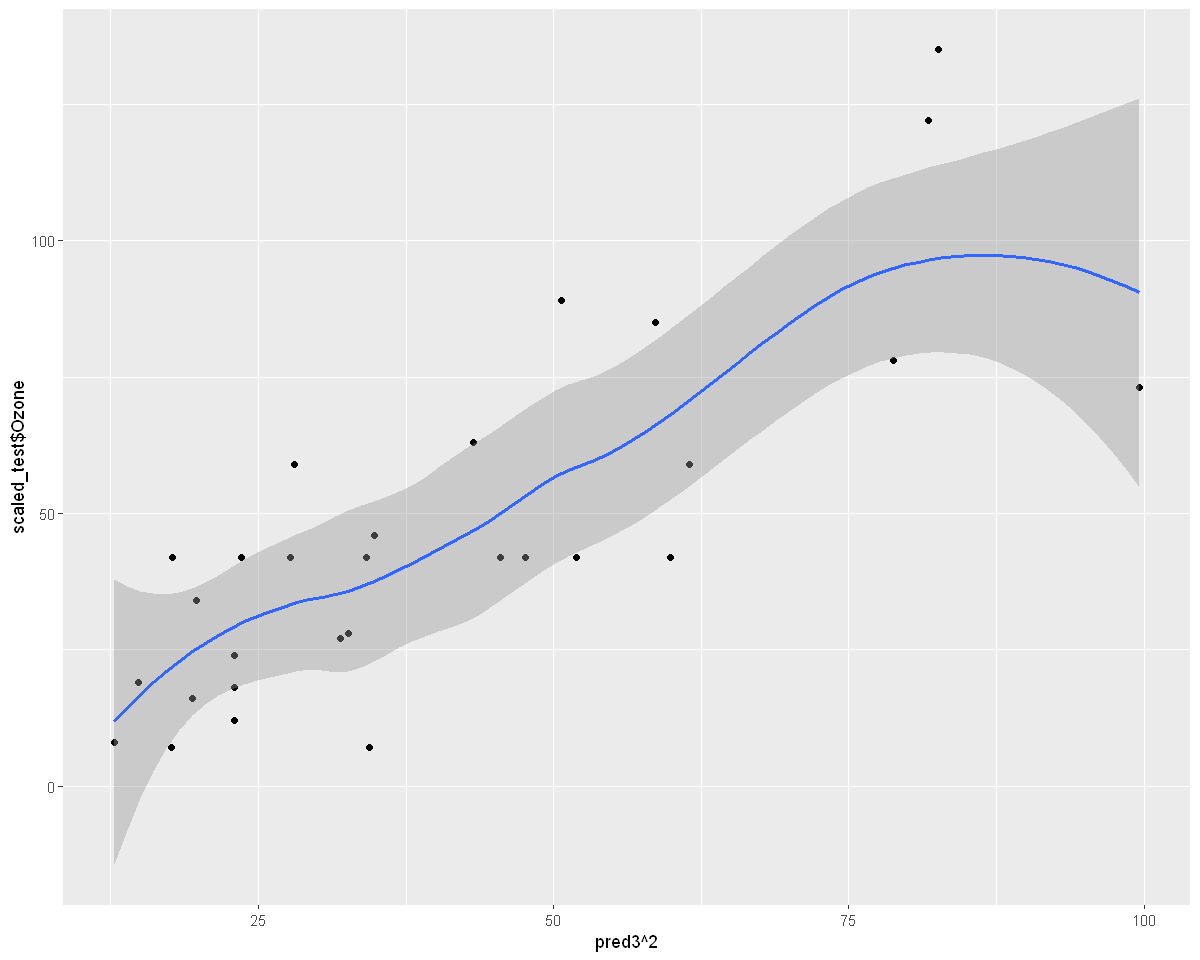

In [51]:
options(repr.plot.width = 10, repr.plot.height = 8)
par(mfrow=c(1,1))
qplot(pred3^2, scaled_test$Ozone) + stat_smooth()

### Check the model whether overfitting or not

In [52]:
model3_rmse_train <- round(sqrt(sum((pred3^2 - scaled_train$Ozone)^2) / length(scaled_train$Ozone)), digits =4)
model3_rmse_train
# Compare training and test RMSE
if (model3_rmse_train < model3_rmse) {
  cat("The model 3 may be overfitting as the training RMSE is lower than the test RMSE.\n")
} else {
  cat("The model 3 shows good generalization as the test RMSE is not significantly higher than the training RMSE.\n")
}

Warning message in pred3^2 - scaled_train$Ozone:
"longer object length is not a multiple of shorter object length"


[1] 39.8257

The model 3 shows good generalization as the test RMSE is not significantly higher than the training RMSE.


In [53]:
if (!require(glmnet)) install.packages('glmnet', dependencies=TRUE) # for ridge regression
suppressWarnings(suppressMessages(library(glmnet)))

Loading required package: glmnet

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8



### Lasso regression model

In [54]:
# Split the data into training and testing sets
set.seed(123)
train_indices <- createDataPartition(df_clean$Ozone, p = 0.7, list = FALSE)
train_data2 <- df_clean[train_indices, ]
test_data2 <- df_clean[-train_indices, ]

In [55]:
control = trainControl(method ="cv", number = 10) # use 10-fold Cross Validation to determine the optimal value for lambda
Grid_la_reg = expand.grid(alpha = 1,  # alpha = 1, Lasso Regression
              lambda = 10^seq(2, -2, by = -.1) )
  
# Training lasso regression model
lasso_model = train(x =train_data2[, c("Solar.R", "Wind", "Temp", "Month", "Day")],
                    y = train_data2$Ozone,
                    method = "glmnet",
                    trControl = control,
                    tuneGrid = Grid_la_reg
                    )
lasso_model

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


glmnet 

109 samples
  5 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 98, 97, 97, 98, 99, 98, ... 
Resampling results across tuning parameters:

  lambda        RMSE      Rsquared    MAE     
    0.01000000  19.32353  0.55369316  15.18515
    0.01258925  19.32353  0.55369316  15.18515
    0.01584893  19.32353  0.55369316  15.18515
    0.01995262  19.32353  0.55369316  15.18515
    0.02511886  19.32353  0.55369316  15.18515
    0.03162278  19.32353  0.55369316  15.18515
    0.03981072  19.32353  0.55369316  15.18515
    0.05011872  19.32353  0.55369316  15.18515
    0.06309573  19.32183  0.55372783  15.18389
    0.07943282  19.31807  0.55386683  15.17908
    0.10000000  19.31339  0.55404787  15.17284
    0.12589254  19.30768  0.55427118  15.16498
    0.15848932  19.30046  0.55456459  15.15499
    0.19952623  19.28950  0.55507892  15.14227
    0.25118864  19.27608  0.55573116  15.13380
    0.31622777  19.26023  0.55652841  15.12823
    0.39

[1] 19.19143

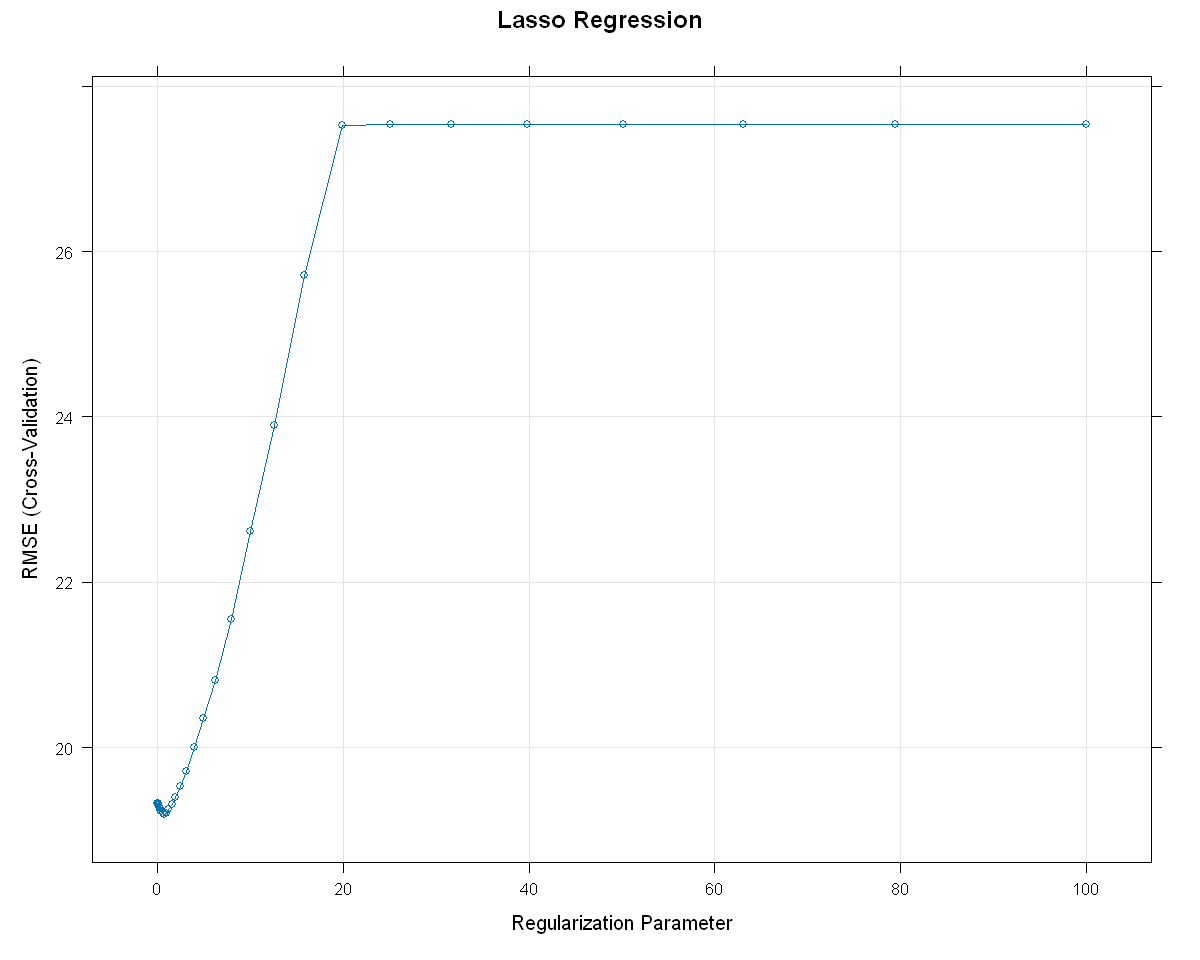

In [56]:
# mean validation score
mean(lasso_model$resample$RMSE)
 
# Plot
plot(lasso_model, main="Lasso Regression")

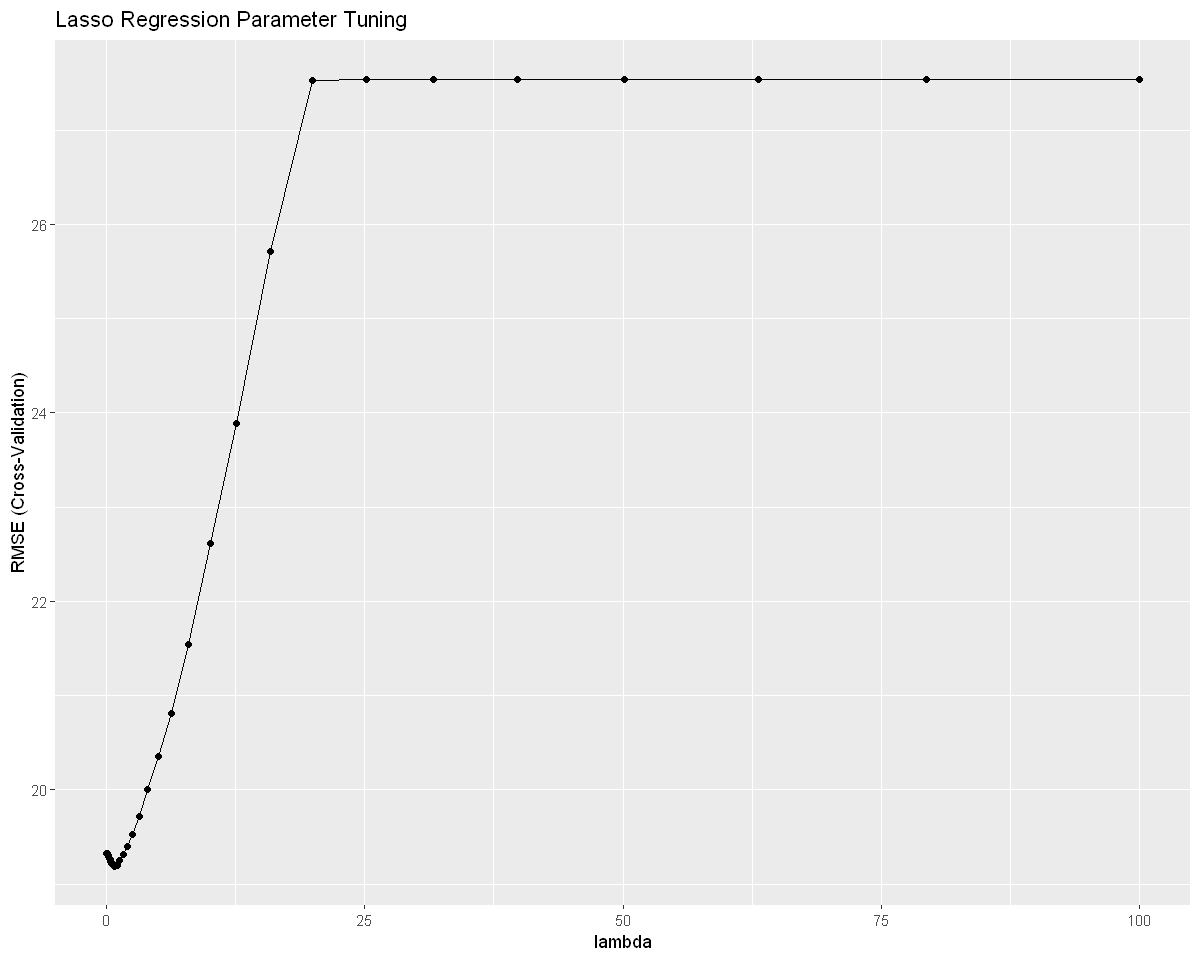

In [57]:
ggplot(lasso_model) +
  labs(title = "Lasso Regression Parameter Tuning", x = "lambda")

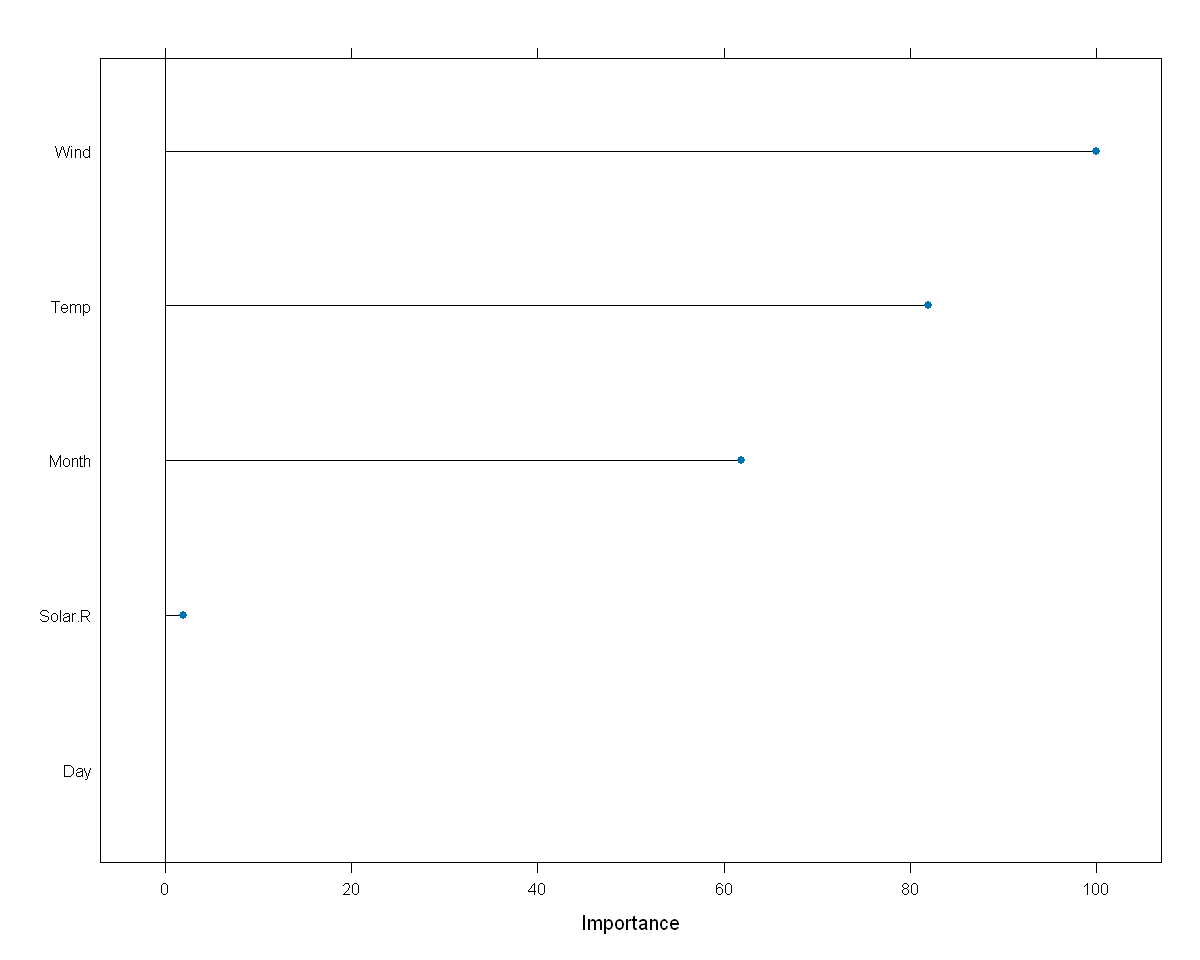

In [58]:
plot(varImp(lasso_model))

In [59]:
lasso_model$bestTune

,alpha,lambda
,<dbl>,<dbl>
20,1,0.7943282


In [60]:
# Access the best resampling results from the train object
best_results <- as.data.frame(lasso_model$results)
optimal_row <- best_results[which.min(best_results$RMSE), ]
# Display the optimal value and tuning parameters
print(optimal_row)

   alpha    lambda     RMSE  Rsquared      MAE   RMSESD RsquaredSD    MAESD
20     1 0.7943282 19.19143 0.5609767 15.14467 5.169519  0.2515422 3.421529


In [61]:
# Extract coefficients from the final Lasso model
lasso_coefficients <- coef(lasso_model$finalModel, s = lasso_model$bestTune$lambda)

# Display the coefficients
print(lasso_coefficients)

6 x 1 sparse Matrix of class "dgCMatrix"
                     s1
(Intercept) -53.6190495
Solar.R       0.0337391
Wind         -1.8022212
Temp          1.4774601
Month        -1.1161797
Day           .        


In [62]:
# Make predictions on the test set using the trained Lasso model
lasso_predictions <- predict(lasso_model, newdata = test_data2[, c("Solar.R", "Wind", "Temp", "Month", "Day")])

# Calculate test accuracy 
lasso_test_rmse <- round(sqrt(sum((lasso_predictions - test_data2$Ozone)^2) / length(test_data2$Ozone)), digits =4)

# Display the test accuracy
print(lasso_test_rmse)

[1] 24.6364


### Ridge Regression

In [63]:
################################
##
## alpha = 0, Ridge Regression
##
################################

# Define predictor variables and the response variable

# Getting the independent variable
x_predictors <- data.matrix(train_data2[, c("Solar.R", "Wind", "Temp", "Month", "Day")])
# Getting the dependent variable
y_response <- train_data2[, "Ozone"]

# Setting the range of lambda values
lambda_seq <- 10^seq(2, -2, by = -.1)

# Ridge Regression
ridge_cv <- cv.glmnet(x_predictors, y_response, type.measure="mae", alpha = 0, lambda = lambda_seq , nfolds=10) 

# Best lambda value
ridge_best_lambda <- ridge_cv$lambda.min
cat("Ridge Best Lambda:" , ridge_best_lambda, "\n")

Ridge Best Lambda: 0.01 


In [64]:
# Rebuilding the model with best lamda value identified
tx <- data.matrix(test_data2[, c("Solar.R", "Wind", "Temp", "Month", "Day")])
ty <- test_data2[, "Ozone"]

ridge_pred <- predict(ridge_cv, s = ridge_best_lambda, newx = tx)

In [65]:
# Evaluate the models
ridge_rmse <- round(sqrt(mean((ridge_pred - test_data2[, "Ozone"])^2)), digits =4)
# Print the RMSE for Ridge and Lasso
cat("Ridge RMSE:", ridge_rmse, "\n")

Ridge RMSE: 24.26 


In [66]:
coef(ridge_cv, s = "lambda.min")

6 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept) -56.76137629
Solar.R       0.03883320
Wind         -1.94230811
Temp          1.58947915
Month        -2.02870843
Day           0.08088421

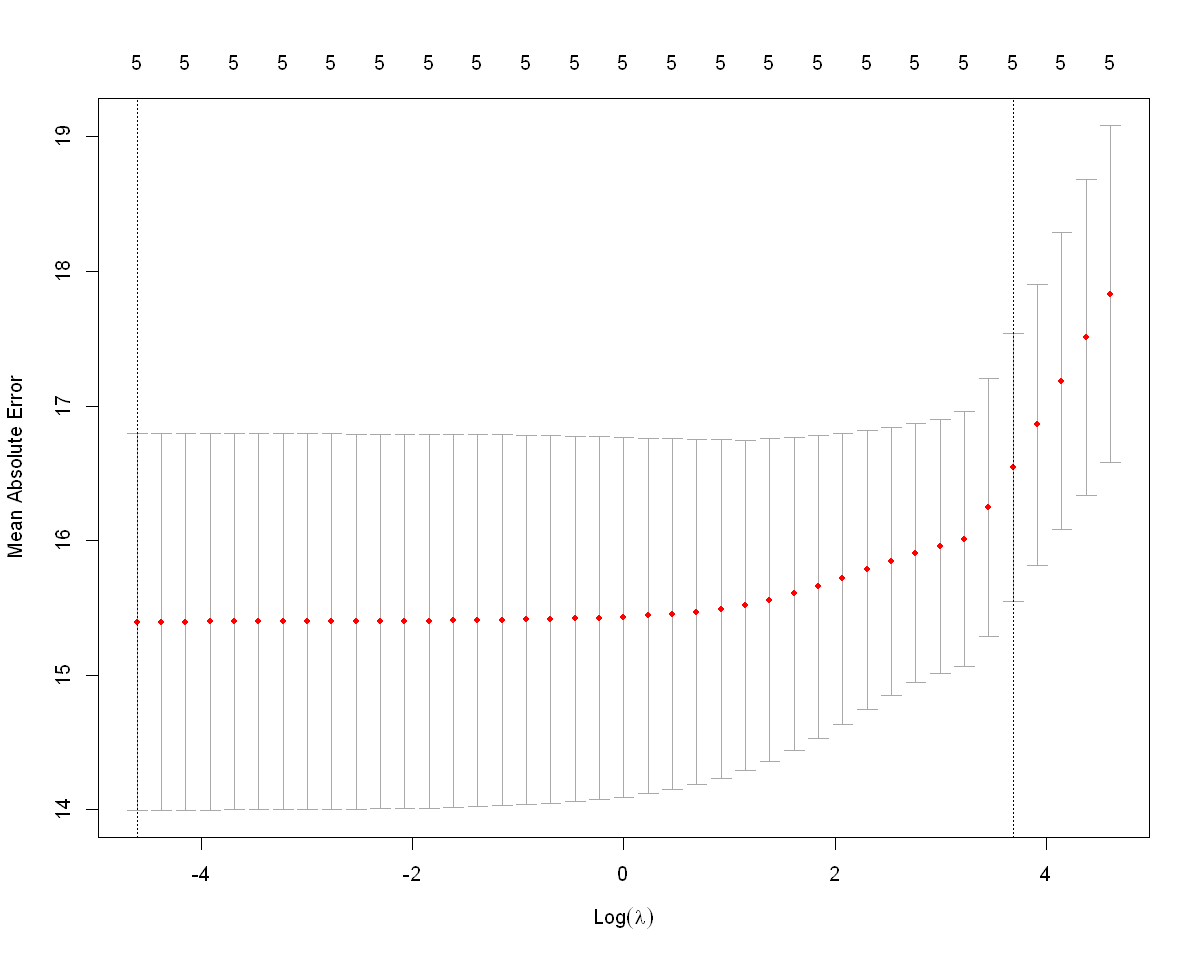

In [67]:
plot(ridge_cv) # The plot has the mean absolute error on the y-axis and the natural log of λ on the x-axis.

#### As λ increases, mean absolute error increases and eventually variables are dropped. The λ that results in the lowest mean absolute error is the dotted line closest to the y-axis. The second dotted line is the lambda that is within 1 standard error of the minimum.

In [68]:
ridge_cv$lambda.1se # when using the one standard error λ

[1] 39.81072

In [69]:
# check the average cross-validated mean absolute error when using the one standard error λ
ridge_cv$cvm[which(ridge_cv$lambda==ridge_cv$lambda.1se)]

[1] 16.54579

<img src="lasso_ridge.jpg" alt="lasso_ridge.jpg" />
    from: https://www.mygreatlearning.com/blog/understanding-of-lasso-regression/

Reference:

    https://medium.com/@dlwilkinson/the-best-way-to-perform-feature-scaling-using-r-and-rstudio-b7a02c16e20f
    https://datatricks.co.uk/feature-scaling-in-r-five-simple-methods
    https://www.reneshbedre.com/blog/get-f-stat-p-value-from-lm.html

    https://rpubs.com/Nitika/linearRegression_Airquality
    https://datascienceplus.com/how-to-apply-linear-regression-in-r/
    https://static-bcrf.biochem.wisc.edu/courses/Tabular-data-analysis-with-R-and-Tidyverse/book/5-workingwithtabulardata.html
    https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/
    https://sparkbyexamples.com/r-programming/convert-list-to-r-dataframe/
    
    https://www.r-bloggers.com/2020/05/simple-guide-to-ridge-regression-in-r/
    https://www.statology.org/ridge-regression-in-r/
    https://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-r.html
    https://www.datacamp.com/tutorial/tutorial-ridge-lasso-elastic-net
    https://www.geeksforgeeks.org/lasso-regression-in-r-programming/?ref=ml_lbp
    https://www.geeksforgeeks.org/ridge-regression-in-r-programming/?ref=ml_lbp
    https://bookdown.org/mpfoley1973/data-sci/ridge.html
    https://statquest.org/video-index/
    https://github.com/StatQuest/ridge_lasso_elastic_net_demo/blob/master/ridge_lass_elastic_net_demo.R
    https://daviddalpiaz.github.io/r4sl/regularization.html